In [ ]:
import pandas as pd

df = pd.read_csv('Cars.comScraped.csv')

print(df.info())
print(df.isnull().sum())
print(df.head())
print(df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10216 entries, 0 to 10215
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Title                   10216 non-null  object 
 1   Dealer                  10082 non-null  object 
 2   Location                0 non-null      float64
 3   State                   10060 non-null  object 
 4   Rating                  9841 non-null   float64
 5   Link                    10216 non-null  object 
 6   Exterior Color          10204 non-null  object 
 7   Interior Color          10204 non-null  object 
 8   Drivetrain              10204 non-null  object 
 9   MPG                     9243 non-null   object 
 10  Fuel Type               9373 non-null   object 
 11  Transmission            10204 non-null  object 
 12  Engine                  10204 non-null  object 
 13  VIN                     10204 non-null  object 
 14  Stock#                  10070 non-null

# Data Cleaning

Scraped data from Cars.com to be cleaned:

1. Remove Duplicates
2. Handle missing values
3. Drop unecessary rows
4. fix dtypes, create more columns for robust features
5. Encode data for model training

# Remove Duplicates

Remove duplicates is a complex function to meticulously remove duplicates based on Vin (if available, else it falls back onto stock#, etc).

This gives a better chance to keep important rows and also work with a large dataset

In [ ]:
def remove_duplicates(df):
    def deduplicate(group):
        if group['VIN'].notna().any():  #If at least one VIN is not null
            return group.drop_duplicates(subset=['VIN'])
        elif group['Stock#'].notna().any():  #If at least one Stock Number is not null
            return group.drop_duplicates(subset=['Stock#'])
        elif group['Mileage'].notna().any():  #If at least one Mileage is not null
            return group.drop_duplicates(subset=['Mileage'])
        else:  #If VIN, Stock Number, and Mileage are all null, use Dealership and Price
            return group.drop_duplicates(subset=['Dealer', 'Price'])

    return df.groupby('Title', group_keys=False).apply(deduplicate).reset_index(drop=True)

df = remove_duplicates(df)

print(df.shape)

(9204, 21)


<ipython-input-2-203ed7a7751a>:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby('Title', group_keys=False).apply(deduplicate).reset_index(drop=True)


# Drop unecessary rows


In [ ]:
df = df.drop(columns=['VIN', 'Stock#', 'Location', 'Link'], errors='ignore')

# Extract and create more Features

In [ ]:
df['Year'] = df['Title'].apply(lambda x: int(x.split(' ')[0])) # extracting the year from title
df['Title'] = df['Title'].str.replace(r'\d{4}', '', regex=True).str.strip() # removing year from title

In [ ]:
import datetime
current_year = datetime.datetime.now().year

df['Car Age'] = current_year - df['Year'] # Car age based on df['Year'] and current year

In [ ]:
df['Make'] = df['Title'].str.split().str[0] # extract the make from title

# Handle Missing Values

In [ ]:
def impute_missing_state(df):
    #Iterate over each dealer
    for dealer, group in df.groupby('Dealer'):
        #Get rows where state is missing
        missing_state_rows = group[group['State'].isnull()]

        if not missing_state_rows.empty:
            #Get the most frequent state for the dealer
            known_states = group[group['State'].notnull()]['State']

            if not known_states.empty:
                #Get the most common state for this dealer
                most_common_state = known_states.mode()[0]

                #Fill missing states with the most common state for the dealer
                df.loc[(df['Dealer'] == dealer) & (df['State'].isnull()), 'State'] = most_common_state

    #Replace any remaining missing States witH UN (Unknown)
    df['State'].fillna('UN', inplace=True)

    return df

df = impute_missing_state(df)

<ipython-input-7-6aaddc09cbe2>:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['State'].fillna('UN', inplace=True)


In [ ]:
df.head(20)

,Title,Dealer,State,Rating,Exterior Color,Interior Color,Drivetrain,MPG,Fuel Type,Transmission,Engine,Mileage,Convenience Features,Entertainment Features,Exterior Features,Safety Features,Price,Year,Car Age,Make
0,Chrysler F-58,Gateway Classic Cars,IL,2.4,Red,White,–,0–0\nBased on EPA mileage ratings. Use for com...,–,3-Speed Manual,4 Cylinder,"28,300 mi.",NaN,NaN,NaN,NaN,"$11,500\n\n\n $1,000 price drop",1926,99,Chrysler
1,Ford Model A Base,Skyway Classics,FL,2.9,Magenta,Tan,–,0–0\nBased on EPA mileage ratings. Use for com...,Gasoline,automatic,350 V8,"17,089 mi.",NaN,NaN,NaN,NaN,"$35,997",1930,95,Ford
2,Ford Pickup Truck Base,Greenwood Automotive,CO,4.9,–,–,–,0–0\nBased on EPA mileage ratings. Use for com...,–,Manual,–,"150,140 mi.",NaN,NaN,NaN,NaN,"$89,995",1940,85,Ford
3,Chevrolet Fleetline Deluxe,California Cars,CA,0.0,Atomic Orange Metallic,Gray,Rear-wheel Drive,0–0\nBased on EPA mileage ratings. Use for com...,Gasoline,Automatic,283 V8,437 mi.,NaN,NaN,NaN,NaN,"$29,900",1951,74,Chevrolet
4,GMC Suburban,Exotic Motorsports of Oklahoma,OK,0.0,Black,Tan,Rear-wheel Drive,0–0\nBased on EPA mileage ratings. Use for com...,–,Automatic 700R4,5.7L V8,570 mi.,NaN,NaN,NaN,NaN,"$49,947\n\n\n $5,000 price drop",1952,73,GMC
5,Chevrolet Bel Air,Joe Basil Chevrolet,NY,4.1,–,–,–,–,–,–,–,"14,633 mi.",NaN,NaN,NaN,NaN,"$65,979",1955,70,Chevrolet
6,Chevrolet Bel Air Base,Marino Performance Motors,FL,0.0,India Ivory and Cashmere Blue,–,–,0–0\nBased on EPA mileage ratings. Use for com...,Gasoline,Two-Speed Automatic (Powerglide),265ci V8,460 mi.,NaN,NaN,NaN,NaN,"$99,900",1955,70,Chevrolet
7,Chevrolet 210 Base,Salem Autosports,WI,2.8,Burgundy,Burgundy,Rear-wheel Drive,0–0\nBased on EPA mileage ratings. Use for com...,Gasoline,Automatic,327 cui V8,692 mi.,NaN,NaN,NaN,NaN,"$39,995",1956,69,Chevrolet
8,Ford F100 Base,Exotic Car Trader,FL,4.4,Metallic Blue,Blue,Rear-wheel Drive,0–0\nBased on EPA mileage ratings. Use for com...,Gasoline,3-Speed Automatic,429ci V8,"1,005 mi.",NaN,NaN,NaN,NaN,"$42,999",1956,69,Ford
9,Ford Thunderbird Base,Motorcar Classics,NY,4.3,Coral Sand,Tuxedo,–,0–0\nBased on EPA mileage ratings. Use for com...,–,Automatic,–,"76,096 mi.",NaN,NaN,NaN,NaN,"$61,900",1957,68,Ford


# Handle Missing Values (cont'd)

In [ ]:
median_rating = df['Rating'][df['Rating'] != 0].median()

# Replace zeros and NaN with the median
df['Rating'] = df['Rating'].replace(0, median_rating)
df['Rating'] = df['Rating'].fillna(median_rating)

In [ ]:
df['Dealer'] = df['Dealer'].fillna('Unknown Dealer')
df['Exterior Color'] = df['Exterior Color'].fillna('Unknown')
df['Interior Color'] = df['Interior Color'].fillna('Unknown')
df['Transmission'] = df['Transmission'].fillna('Unknown')
df['Engine'] = df['Engine'].fillna('Unknown')
df['Convenience Features'] = df['Convenience Features'].fillna('Unknown')
df['Entertainment Features'] = df['Entertainment Features'].fillna('Unknown')
df['Exterior Features'] = df['Exterior Features'].fillna('Unknown')
df['Safety Features'] = df['Safety Features'].fillna('Unknown')

In [ ]:
df['Dealer'].value_counts()

,count
Dealer,
Unknown Dealer,122
Utter Family of Dealerships,34
Kendall Ford of Eugene,31
Gallatin Subaru,31
ALM Hyundai Lumberton,28
...,...
Federico Dodge Chrysler Jeep RAM,1
Showcase Auto Sales,1
Uinta CDJR,1


# Simplify Values for better understanding

In [ ]:
import numpy as np

# Replacing values
df['Drivetrain'] = df['Drivetrain'].replace({
    '–': np.nan,
    'Unknown': np.nan,
    'AWD': 'All-wheel Drive',
    'FWD': 'Front-wheel Drive',
    '4WD': 'Four-wheel Drive',
    'All Wheel Drive': 'All-wheel Drive'
})
# Handle missing values
df['Drivetrain'] = df['Drivetrain'].fillna(df['Drivetrain'].mode()[0])

df['Drivetrain'].unique()

array(['All-wheel Drive', 'Rear-wheel Drive', 'Four-wheel Drive',
       'Front-wheel Drive'], dtype=object)

In [ ]:
# Removing extra text
df['MPG'] = df['MPG'].str.replace(r'\n.*', '', regex=True)
df['MPG'] = df['MPG'].str.strip()

# Split the MPG range into two columns (lower and upper values)
df[['MPG_Lower', 'MPG_Upper']] = df['MPG'].str.split('–', expand=True)

# Convert both to numeric
df['MPG_Lower'] = pd.to_numeric(df['MPG_Lower'], errors='coerce')
df['MPG_Upper'] = pd.to_numeric(df['MPG_Upper'], errors='coerce')

df = df.drop('MPG', axis=1) # Drop MPG to prevent redunduncy

In [ ]:
# Handle missing values
df['MPG_Lower'].fillna(df['MPG_Lower'].median(), inplace=True)
df['MPG_Upper'].fillna(df['MPG_Upper'].median(), inplace=True)

<ipython-input-14-b6a81fec79cf>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['MPG_Lower'].fillna(df['MPG_Lower'].median(), inplace=True)
<ipython-input-14-b6a81fec79cf>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=Tr

In [ ]:
# Replace values for simplifiaction
df['Fuel Type'] = df['Fuel Type'].replace({
    '–': np.nan,
    'Unspecified': np.nan,
    'PHEV (plug-in hybrid electric vehicle)': 'Hybrid',
    'Gas Hybrid': 'Hybrid',
    'Plug-In Hybrid': 'Hybrid',
    'Gaseous': 'Gasoline'
})

df['Fuel Type'] = df['Fuel Type'].fillna(df['Fuel Type'].mode()[0])

df['Fuel Type'].unique()

array(['Gasoline', 'Diesel', 'E85 Flex Fuel', 'Hybrid', 'All-Electric'],
      dtype=object)

In [ ]:
df['Transmission'] = df['Transmission'].fillna('Unknown') # Replace with Unknown first

# Standardize Text
df['Transmission'] = df['Transmission'].astype(str).str.lower().str.strip()

# Categorize Data into Automatic, Manual, Semi-Automatic, and Unclassified
def categorize_transmission(row):
    if any(keyword in row for keyword in ['automatic', 'Automatic', 'Auto', 'auto', 'A/T', 'a/t', 'cv', 'A', '1A', '8A']):
        return 'Automatic'
    elif 'manual' in row or 'm/t' in row or 'M/T' in row or 'Manual' in row:
        return 'Manual'
    elif any(keyword in row for keyword in ['dual', 'clutch', 'sportmatic', 'pdk', 'dsg', 'shiftable', 'geartronic', 'tiptronic', 'steptronic', 'eco', 'powershift', 'Sport', 'sport']):
        return 'Semi-Automatic'
    else:
        return 'Unclassified'

df['Transmission'] = df['Transmission'].apply(categorize_transmission)

print(df['Transmission'].unique())

['Manual' 'Automatic' 'Unclassified' 'Semi-Automatic']


In [ ]:
# Cleaning Mileage column
df['Mileage'] = df['Mileage'].str.replace(',', '', regex=False)  # remove commas
df['Mileage'] = df['Mileage'].str.replace(' mi.', '', regex=False)  # remove ' mi.'
df['Mileage'] = pd.to_numeric(df['Mileage'], errors='coerce')  # convert to numeric

In [ ]:
df['Mileage'] = df['Mileage'].fillna(df['Mileage'].median()) # Handle missing values (HMV)

In [ ]:
import re

# Function to extract the first dollar amount
def clean_price(price):
    match = re.search(r'\$\d{1,3}(?:,\d{3})*(?:\.\d{2})?', str(price))
    return match.group(0) if match else None

df['Price'] = df['Price'].apply(clean_price)

df['Price'] = df['Price'].replace('[\$,]', '', regex=True).astype(float)

In [ ]:
df['Price'] = df['Price'].fillna(df['Price'].median()) # HMV

In [ ]:
df.head(20)

,Title,Dealer,State,Rating,Exterior Color,Interior Color,Drivetrain,Fuel Type,Transmission,Engine,...,Convenience Features,Entertainment Features,Exterior Features,Safety Features,Price,Year,Car Age,Make,MPG_Lower,MPG_Upper
0,Chrysler F-58,Gateway Classic Cars,IL,2.4,Red,White,All-wheel Drive,Gasoline,Manual,4 Cylinder,...,Unknown,Unknown,Unknown,Unknown,11500.0,1926,99,Chrysler,0.0,0.0
1,Ford Model A Base,Skyway Classics,FL,2.9,Magenta,Tan,All-wheel Drive,Gasoline,Automatic,350 V8,...,Unknown,Unknown,Unknown,Unknown,35997.0,1930,95,Ford,0.0,0.0
2,Ford Pickup Truck Base,Greenwood Automotive,CO,4.9,–,–,All-wheel Drive,Gasoline,Manual,–,...,Unknown,Unknown,Unknown,Unknown,89995.0,1940,85,Ford,0.0,0.0
3,Chevrolet Fleetline Deluxe,California Cars,CA,4.6,Atomic Orange Metallic,Gray,Rear-wheel Drive,Gasoline,Automatic,283 V8,...,Unknown,Unknown,Unknown,Unknown,29900.0,1951,74,Chevrolet,0.0,0.0
4,GMC Suburban,Exotic Motorsports of Oklahoma,OK,4.6,Black,Tan,Rear-wheel Drive,Gasoline,Automatic,5.7L V8,...,Unknown,Unknown,Unknown,Unknown,49947.0,1952,73,GMC,0.0,0.0
5,Chevrolet Bel Air,Joe Basil Chevrolet,NY,4.1,–,–,All-wheel Drive,Gasoline,Unclassified,–,...,Unknown,Unknown,Unknown,Unknown,65979.0,1955,70,Chevrolet,21.0,28.0
6,Chevrolet Bel Air Base,Marino Performance Motors,FL,4.6,India Ivory and Cashmere Blue,–,All-wheel Drive,Gasoline,Automatic,265ci V8,...,Unknown,Unknown,Unknown,Unknown,99900.0,1955,70,Chevrolet,0.0,0.0
7,Chevrolet 210 Base,Salem Autosports,WI,2.8,Burgundy,Burgundy,Rear-wheel Drive,Gasoline,Automatic,327 cui V8,...,Unknown,Unknown,Unknown,Unknown,39995.0,1956,69,Chevrolet,0.0,0.0
8,Ford F100 Base,Exotic Car Trader,FL,4.4,Metallic Blue,Blue,Rear-wheel Drive,Gasoline,Automatic,429ci V8,...,Unknown,Unknown,Unknown,Unknown,42999.0,1956,69,Ford,0.0,0.0
9,Ford Thunderbird Base,Motorcar Classics,NY,4.3,Coral Sand,Tuxedo,All-wheel Drive,Gasoline,Automatic,–,...,Unknown,Unknown,Unknown,Unknown,61900.0,1957,68,Ford,0.0,0.0


In [ ]:
# Remove rows with cars that are less than 0 years old
df = df[df['Car Age'] >= 0]

# Remove rows with abnormally high Mileage
df = df[df['Mileage'] < 500000]

# Remove rows with abnormally high Price
df = df[df['Price'] < 1000000]

In [ ]:
# Ensure correct dtypes
df['Year'] = pd.to_numeric(df['Year'], errors='coerce')
df['Car Age'] = pd.to_numeric(df['Car Age'], errors='coerce')
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')
df['Mileage'] = pd.to_numeric(df['Mileage'], errors='coerce')

In [ ]:
# Engine column simplification
def simplify_engine(engine_desc):
    engine_desc = engine_desc.lower()
    if 'electric' in engine_desc:
        return 'Electric'
    elif 'hybrid' in engine_desc:
        return 'Hybrid'
    elif 'flexible fuel' in engine_desc:
        return 'Flexible Fuel'
    elif 'gasoline' in engine_desc:
        return 'Gasoline'
    else:
        return 'Other'

df['EngineType'] = df['Engine'].apply(simplify_engine)
print(df['EngineType'].value_counts())

EngineType
Other            5012
Gasoline         2860
Electric          779
Hybrid            468
Flexible Fuel      70
Name: count, dtype: int64


In [ ]:
# Extracting Engine Size and Engine cylinder
def extract_engine_features(engine_desc):
    size = re.search(r'\d+(\.\d+)?L', engine_desc)
    size = size.group() if size else None

    cyl = re.search(r'([IV])[- ]?\d', engine_desc)
    cyl = cyl.group() if cyl else None

    return pd.Series([size, cyl])

df[['EngineSize', 'Cylinder']] = df['Engine'].apply(lambda x: extract_engine_features(str(x)))

In [ ]:
# HMV
engine_size_mode = df['EngineSize'].mode()[0]
cylinder_mode = df['Cylinder'].mode()[0]

df['EngineSize'] = df['EngineSize'].fillna(engine_size_mode)
df['Cylinder'] = df['Cylinder'].fillna(cylinder_mode)

In [ ]:
print(df.shape)

(9189, 24)


In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 9189 entries, 0 to 9192
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Title                   9189 non-null   object 
 1   Dealer                  9189 non-null   object 
 2   State                   9189 non-null   object 
 3   Rating                  9189 non-null   float64
 4   Exterior Color          9189 non-null   object 
 5   Interior Color          9189 non-null   object 
 6   Drivetrain              9189 non-null   object 
 7   Fuel Type               9189 non-null   object 
 8   Transmission            9189 non-null   object 
 9   Engine                  9189 non-null   object 
 10  Mileage                 9189 non-null   float64
 11  Convenience Features    9189 non-null   object 
 12  Entertainment Features  9189 non-null   object 
 13  Exterior Features       9189 non-null   object 
 14  Safety Features         9189 non-null   objec

In [ ]:
df.head(40)

,Title,Dealer,State,Rating,Exterior Color,Interior Color,Drivetrain,Fuel Type,Transmission,Engine,...,Safety Features,Price,Year,Car Age,Make,MPG_Lower,MPG_Upper,EngineType,EngineSize,Cylinder
0,Chrysler F-58,Gateway Classic Cars,IL,2.4,Red,White,All-wheel Drive,Gasoline,Manual,4 Cylinder,...,Unknown,11500.0,1926,99,Chrysler,0.0,0.0,Other,2L,I-4
1,Ford Model A Base,Skyway Classics,FL,2.9,Magenta,Tan,All-wheel Drive,Gasoline,Automatic,350 V8,...,Unknown,35997.0,1930,95,Ford,0.0,0.0,Other,2L,V8
2,Ford Pickup Truck Base,Greenwood Automotive,CO,4.9,–,–,All-wheel Drive,Gasoline,Manual,–,...,Unknown,89995.0,1940,85,Ford,0.0,0.0,Other,2L,I-4
3,Chevrolet Fleetline Deluxe,California Cars,CA,4.6,Atomic Orange Metallic,Gray,Rear-wheel Drive,Gasoline,Automatic,283 V8,...,Unknown,29900.0,1951,74,Chevrolet,0.0,0.0,Other,2L,V8
4,GMC Suburban,Exotic Motorsports of Oklahoma,OK,4.6,Black,Tan,Rear-wheel Drive,Gasoline,Automatic,5.7L V8,...,Unknown,49947.0,1952,73,GMC,0.0,0.0,Other,5.7L,V8
5,Chevrolet Bel Air,Joe Basil Chevrolet,NY,4.1,–,–,All-wheel Drive,Gasoline,Unclassified,–,...,Unknown,65979.0,1955,70,Chevrolet,21.0,28.0,Other,2L,I-4
6,Chevrolet Bel Air Base,Marino Performance Motors,FL,4.6,India Ivory and Cashmere Blue,–,All-wheel Drive,Gasoline,Automatic,265ci V8,...,Unknown,99900.0,1955,70,Chevrolet,0.0,0.0,Other,2L,V8
7,Chevrolet 210 Base,Salem Autosports,WI,2.8,Burgundy,Burgundy,Rear-wheel Drive,Gasoline,Automatic,327 cui V8,...,Unknown,39995.0,1956,69,Chevrolet,0.0,0.0,Other,2L,V8
8,Ford F100 Base,Exotic Car Trader,FL,4.4,Metallic Blue,Blue,Rear-wheel Drive,Gasoline,Automatic,429ci V8,...,Unknown,42999.0,1956,69,Ford,0.0,0.0,Other,2L,V8
9,Ford Thunderbird Base,Motorcar Classics,NY,4.3,Coral Sand,Tuxedo,All-wheel Drive,Gasoline,Automatic,–,...,Unknown,61900.0,1957,68,Ford,0.0,0.0,Other,2L,I-4


In [ ]:
df.to_csv('Basic_Cleaned_Cars.csv', index=False) # Saved for Basic EDA

# Encoding Columns to train, test and fit in models

In [ ]:
def extract_unique_features(df, column_name):
    all_features = []
    for features in df[column_name]:
        if isinstance(features, str):
            feature_list = [feature.strip() for feature in features.split(',')]
            all_features.extend(feature_list)
    return sorted(set(all_features))

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer


def process_and_encode_column_features(df, column_name):
    """
    Converts string entries in a column to lists, ensures all entries are lists,
    and applies one-hot encoding using MultiLabelBinarizer.
    """
    #Convert string entries into lists
    df[column_name] = df[column_name].apply(lambda x: x.split(', ') if isinstance(x, str) else x)

    #Identify missing entries
    missing_mask = df[column_name].isna() | df[column_name].apply(lambda x: isinstance(x, list) and len(x) == 0)

    #Ensure all entries are lists
    df[column_name] = df[column_name].apply(lambda x: x if isinstance(x, list) and x else [])

    #Initialize MultiLabelBinarizer
    mlb = MultiLabelBinarizer()

    #Apply one-hot encoding
    df_encoded = pd.DataFrame(mlb.fit_transform(df[column_name]),
                              columns=[f"{column_name}_{class_name}" for class_name in mlb.classes_],
                              index=df.index)

    #Add the Missing feature column based on missing_mask
    df_encoded[f"{column_name}_Missing"] = missing_mask.astype(int)

    #Concatenate the new features with the original DataFrame
    df = pd.concat([df.drop(columns=[column_name]), df_encoded], axis=1)

    return df

# Separate each value into integer columns

In [ ]:
df = pd.get_dummies(df, columns=['State'], dtype=int)

In [ ]:
df = pd.get_dummies(df, columns=['Drivetrain'], prefix='Drivetrain', drop_first=False)
df[df.columns[df.columns.str.startswith('Drivetrain')]] = df[df.columns[df.columns.str.startswith('Drivetrain')]].astype(int)

In [ ]:
df = pd.get_dummies(df, columns=['Fuel Type'], dtype=int)

In [ ]:
df = pd.get_dummies(df, columns=['Transmission'], prefix='Transmission_Type', dtype=int)

In [ ]:
df = pd.get_dummies(df, columns=['EngineType'], dtype=int)

# The average mean price for differnt types of engine types

Gives great insight into the correlation of engine type to price.

1. Hybrid cars are ~$2,000 more expensive than non-Hybrid cars on average.

2. Electric cars are WAY more expensive (~$20,000 more) than non-Electric cars!

3. Flexible Fuel cars are cheaper (~$9,000 less) than non-Flexible Fuel cars.

4. Gasoline cars are more expensive (~$9,500 more) than non-Gasoline cars.

Hence, the type of engine do impact prices of cars.

In [ ]:
print(df.groupby('EngineType_Hybrid')['Price'].mean())
print(df.groupby('EngineType_Electric')['Price'].mean())
print(df.groupby('EngineType_Flexible Fuel')['Price'].mean())
print(df.groupby('EngineType_Gasoline')['Price'].mean())

EngineType_Hybrid
0    42143.865726
1    44337.139957
Name: Price, dtype: float64
EngineType_Electric
0    40592.763674
1    60207.050064
Name: Price, dtype: float64
EngineType_Flexible Fuel
0    42326.283474
1    33043.650000
Name: Price, dtype: float64
EngineType_Gasoline
0    39272.326829
1    48857.300000
Name: Price, dtype: float64


Just to make sure, an ANOVA test was run and ...


**Engine Type has a statistically significant effect on Price.**

In [ ]:
import scipy.stats as stats

# Create price groups
hybrid_prices = df[df['EngineType_Hybrid'] == 1]['Price']
electric_prices = df[df['EngineType_Electric'] == 1]['Price']
flexible_prices = df[df['EngineType_Flexible Fuel'] == 1]['Price']
gasoline_prices = df[df['EngineType_Gasoline'] == 1]['Price']

# Run ANOVA
f_stat, p_value = stats.f_oneway(hybrid_prices, electric_prices, flexible_prices, gasoline_prices)

print(f"ANOVA F-statistic: {f_stat}")
print(f"ANOVA p-value: {p_value}")

ANOVA F-statistic: 13.005601971908401
ANOVA p-value: 1.8763788529184165e-08


In [ ]:
df.head(20)

,Title,Dealer,Rating,Exterior Color,Interior Color,Engine,Mileage,Convenience Features,Entertainment Features,Exterior Features,...,Fuel Type_Hybrid,Transmission_Type_Automatic,Transmission_Type_Manual,Transmission_Type_Semi-Automatic,Transmission_Type_Unclassified,EngineType_Electric,EngineType_Flexible Fuel,EngineType_Gasoline,EngineType_Hybrid,EngineType_Other
0,Chrysler F-58,Gateway Classic Cars,2.4,Red,White,4 Cylinder,28300.0,Unknown,Unknown,Unknown,...,0,0,1,0,0,0,0,0,0,1
1,Ford Model A Base,Skyway Classics,2.9,Magenta,Tan,350 V8,17089.0,Unknown,Unknown,Unknown,...,0,1,0,0,0,0,0,0,0,1
2,Ford Pickup Truck Base,Greenwood Automotive,4.9,–,–,–,150140.0,Unknown,Unknown,Unknown,...,0,0,1,0,0,0,0,0,0,1
3,Chevrolet Fleetline Deluxe,California Cars,4.6,Atomic Orange Metallic,Gray,283 V8,437.0,Unknown,Unknown,Unknown,...,0,1,0,0,0,0,0,0,0,1
4,GMC Suburban,Exotic Motorsports of Oklahoma,4.6,Black,Tan,5.7L V8,570.0,Unknown,Unknown,Unknown,...,0,1,0,0,0,0,0,0,0,1
5,Chevrolet Bel Air,Joe Basil Chevrolet,4.1,–,–,–,14633.0,Unknown,Unknown,Unknown,...,0,0,0,0,1,0,0,0,0,1
6,Chevrolet Bel Air Base,Marino Performance Motors,4.6,India Ivory and Cashmere Blue,–,265ci V8,460.0,Unknown,Unknown,Unknown,...,0,1,0,0,0,0,0,0,0,1
7,Chevrolet 210 Base,Salem Autosports,2.8,Burgundy,Burgundy,327 cui V8,692.0,Unknown,Unknown,Unknown,...,0,1,0,0,0,0,0,0,0,1
8,Ford F100 Base,Exotic Car Trader,4.4,Metallic Blue,Blue,429ci V8,1005.0,Unknown,Unknown,Unknown,...,0,1,0,0,0,0,0,0,0,1
9,Ford Thunderbird Base,Motorcar Classics,4.3,Coral Sand,Tuxedo,–,76096.0,Unknown,Unknown,Unknown,...,0,1,0,0,0,0,0,0,0,1


# Extract and Encode extra car features for more robustness

In [ ]:
unique_convenience_features = extract_unique_features(df, 'Convenience Features')
print(unique_convenience_features)

['Adaptive Cruise Control', 'Automatic Parking', 'Autopilot', 'Cooled Seats', 'Heated Seats', 'Heated Steering Wheel', 'Keyless Entry', 'Keyless Start', 'Navigation System', 'Power Folding Mirrors', 'Power Liftgate', 'Remote Start', 'Unknown']


In [ ]:
unique_entertainment_features = extract_unique_features(df, 'Entertainment Features')
print(unique_entertainment_features)

['Android Auto®', 'Apple CarPlay®', 'Apple CarPlay®/Android Auto®', 'Bluetooth®', 'CD Player', 'DVD Player', 'HomeLink', 'Premium Sound System', 'Rear Seat Entertainment', 'Satellite Radio', 'USB Port', 'Unknown', 'WiFi Hotspot']


In [ ]:
unique_exterior_features = extract_unique_features(df, 'Exterior Features')
print(unique_exterior_features)

['Alloy Wheels', 'Moonroof', 'Roof Rack', 'Sunroof/Moonroof', 'Tow Hitch', 'Tow Hooks', 'Unknown']


In [ ]:
unique_safety_features = extract_unique_features(df, 'Safety Features')
print(unique_safety_features)

['Automatic Emergency Braking', 'Backup Camera', 'Blind Spot Monitor', 'Brake Assist', 'LED Headlights', 'Lane Departure Warning', 'Rain Sensing Wipers', 'Rear Cross Traffic Alert', 'Stability Control', 'Unknown']


In [ ]:
df = process_and_encode_column_features(df, 'Convenience Features')

df = process_and_encode_column_features(df, 'Entertainment Features')

df = process_and_encode_column_features(df, 'Exterior Features')

df = process_and_encode_column_features(df, 'Safety Features')

In [ ]:
print(df.columns.tolist())

['Title', 'Dealer', 'Rating', 'Exterior Color', 'Interior Color', 'Engine', 'Mileage', 'Price', 'Year', 'Car Age', 'Make', 'MPG_Lower', 'MPG_Upper', 'EngineSize', 'Cylinder', 'State_AK', 'State_AL', 'State_AR', 'State_AZ', 'State_CA', 'State_CO', 'State_CT', 'State_DE', 'State_FL', 'State_GA', 'State_HI', 'State_IA', 'State_ID', 'State_IL', 'State_IN', 'State_KS', 'State_KY', 'State_LA', 'State_MA', 'State_MD', 'State_ME', 'State_MI', 'State_MN', 'State_MO', 'State_MS', 'State_MT', 'State_NC', 'State_ND', 'State_NE', 'State_NH', 'State_NJ', 'State_NM', 'State_NV', 'State_NY', 'State_OH', 'State_OK', 'State_OR', 'State_PA', 'State_RI', 'State_SC', 'State_SD', 'State_TN', 'State_TX', 'State_UN', 'State_UT', 'State_VA', 'State_VT', 'State_WA', 'State_WI', 'State_WV', 'State_WY', 'Drivetrain_All-wheel Drive', 'Drivetrain_Four-wheel Drive', 'Drivetrain_Front-wheel Drive', 'Drivetrain_Rear-wheel Drive', 'Fuel Type_All-Electric', 'Fuel Type_Diesel', 'Fuel Type_E85 Flex Fuel', 'Fuel Type_Gasol

# Standardize Numeric columns

In [ ]:
from sklearn.preprocessing import StandardScaler
import joblib

columns_to_scale = ['Mileage', 'Price', 'Year', 'MPG_Lower', 'MPG_Upper']

scaler = StandardScaler()
scaler.fit(df[columns_to_scale])
joblib.dump(scaler, 'scaler.pkl')

df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

print(df[columns_to_scale].head())

In [ ]:
df.to_csv('Cleaned_and_Encoded_Cars.csv', index=False) # Saved for Advanced EDA

# Test the R^2 score and MSE for Linear Regression and Random Forest
To see how well the data will fit.

In [ ]:
X = df.drop(columns=['Price'])
y = df['Price']

X = pd.get_dummies(X, drop_first=True)

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [ ]:
y_pred = model.predict(X_test)

from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

# Overall decent score and will provide decent results but might need to improve

Mean Squared Error: 0.47874502621283177
R^2 Score: 0.5672691552449176


In [ ]:
feature_importance = model.coef_  # For linear regression, it shows feature importance
feature_importance_df = pd.DataFrame(feature_importance, index=X.columns, columns=["Importance"])

print(feature_importance_df.sort_values("Importance", ascending=False))

                                             Importance
Title_Ferrari 488 Pista Spider Base            5.167202
Make_Ferrari                                   4.937713
EngineSize_6.5L                                4.156110
Title_Chevrolet Bel Air                        3.508184
Exterior Color_Verde Kers                      3.313723
...                                                 ...
Dealer_Opelika Ford Chrysler Dodge Jeep Ram   -1.529648
Title_Ferrari Portofino Base                  -2.201385
Title_Ferrari Roma .                          -2.247371
Title_Ferrari California T                    -2.328362
Exterior Color_Grigio Titanio Metallic        -2.987854

[12387 rows x 1 columns]


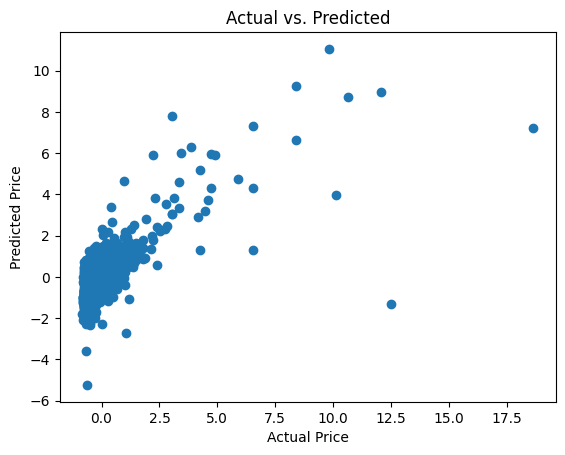

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs. Predicted")
plt.show()

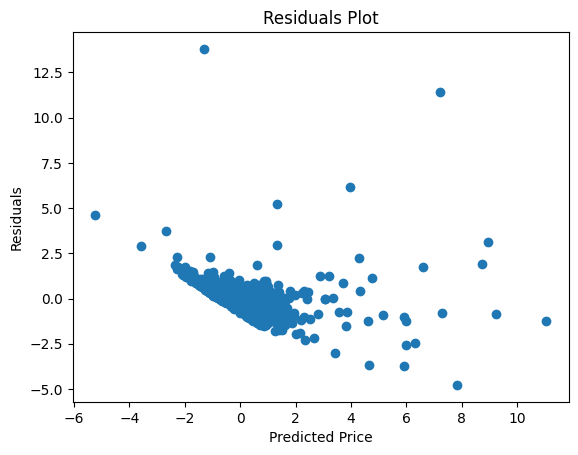

In [ ]:
residuals = y_test - y_pred
plt.scatter(y_pred, residuals)
plt.xlabel("Predicted Price")
plt.ylabel("Residuals")
plt.title("Residuals Plot")
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest - Mean Squared Error: {mse_rf}")
print(f"Random Forest - R^2 Score: {r2_rf}")

# Best Results (mostly because random forest does best with non-linear relationaships)

Random Forest - Mean Squared Error: 0.17768051939615048
Random Forest - R^2 Score: 0.8393970964815066


# Exploratory Data Analysis

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor

In [ ]:
df = pd.read_csv("Cleaned_and_Encoded_Cars.csv")

# Normalizing Price and Mileage
To improve the clarity of our visualizations, we will normalize Price and Mileage.

In [ ]:
df['Price'] = (df['Price'] - df['Price'].mean()) / df['Price'].std()
df['Mileage'] = (df['Mileage'] - df['Mileage'].mean()) / df['Mileage'].std()

# Normalized Price Distribution

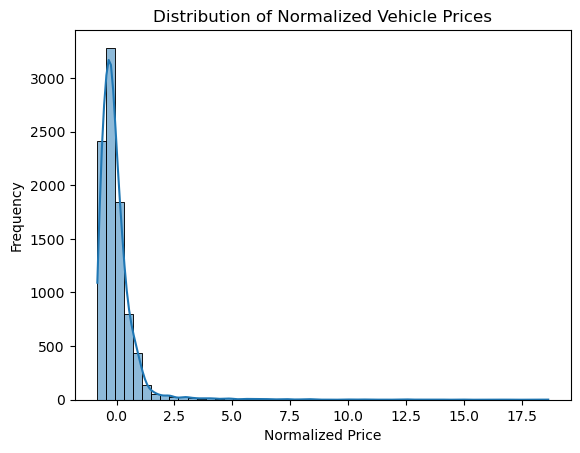

In [ ]:
sns.histplot(df['Price'], kde=True, bins=50)
plt.title("Distribution of Normalized Vehicle Prices")
plt.xlabel("Normalized Price")
plt.ylabel("Frequency")
plt.show()

The distribution of vehicle prices appears slightly right skewed which suggests that while most vehicles fall within a moderate price range, there are still a number of high-priced listings that extend the tail of the distribution. The central peak indicates a strong clustering of vehicles around the average market price.

# Feature Importance Analysis (Random Forest)

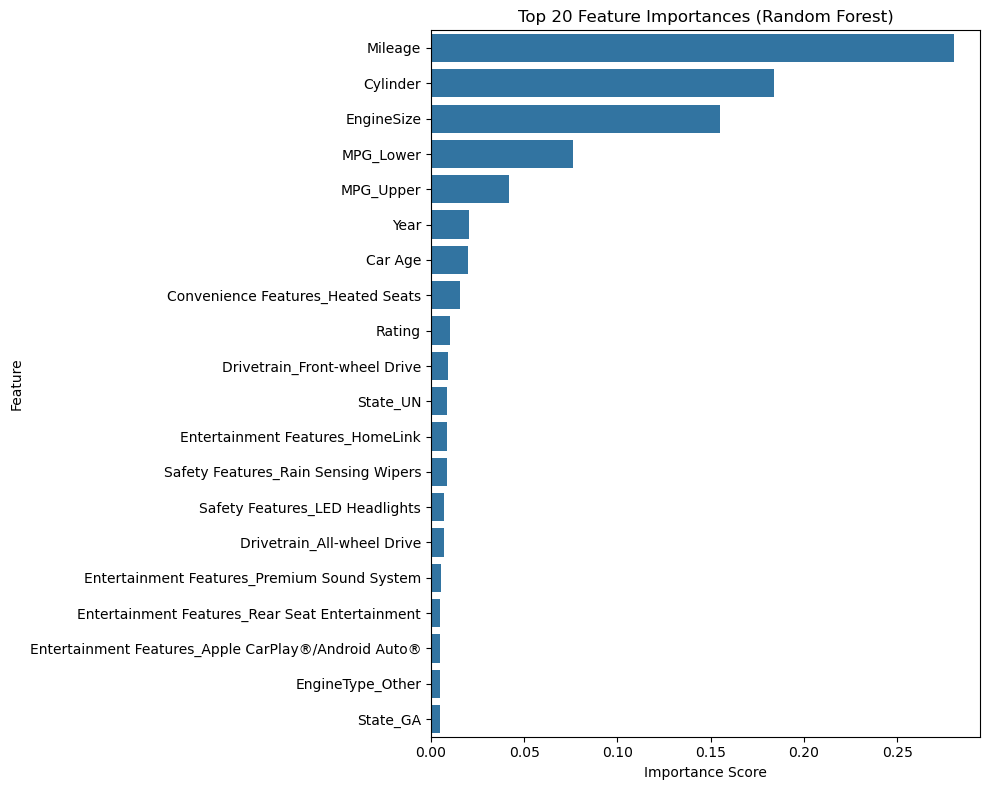

In [ ]:
from sklearn.ensemble import RandomForestRegressor

df['EngineSize'] = df['EngineSize'].astype(str).str.extract(r'(\d+\.?\d*)').astype(float)
df['Cylinder'] = df['Cylinder'].astype(str).str.extract(r'(\d+)').astype(float)

y = df['Price']

numerical_features = ['Rating', 'Mileage', 'Year', 'Car Age', 'MPG_Lower', 'MPG_Upper', 'EngineSize', 'Cylinder']
encoded_features = [col for col in df.columns if any(col.startswith(prefix) for prefix in [
    'Make_', 'EngineType_', 'State_', 'Drivetrain_', 'Fuel Type_', 'Transmission_Type_',
    'Convenience Features_', 'Entertainment Features_', 'Safety Features_', 'Exterior Features_'])]

X = df[numerical_features + encoded_features]

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)

top_20 = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False).head(20)

plt.figure(figsize=(10, 8))
sns.barplot(x=top_20.values, y=top_20.index)
plt.title("Top 20 Feature Importances (Random Forest)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


# Correlation Among Numerical Features

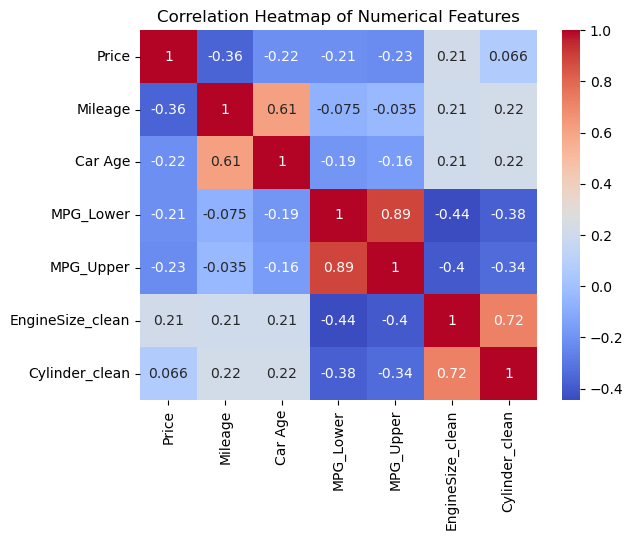

In [ ]:
# Remove non-digit characters from numeric-like strings and convert
df['EngineSize_clean'] = df['EngineSize'].str.extract(r'(\d+\.?\d*)').astype(float)
df['Cylinder_clean'] = df['Cylinder'].str.extract(r'(\d+)').astype(float)


sns.heatmap(df[['Price', 'Mileage', 'Car Age', 'MPG_Lower', 'MPG_Upper', 'EngineSize_clean', 'Cylinder_clean']].corr(),
            annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap of Numerical Features")
plt.show()

- Mileage has a moderate negative correlation with Price (-0.36), reinforcing the depreciation effect of high usage.
- Car Age also shows a negative relationship with price (-0.22), as expected.
- MPG_Lower and MPG_Upper are highly correlated with each other (0.89), but weakly (and negatively) associated with price. This reflects the fact that more fuel-efficient vehicles tend to be lower-cost.
- Engine Size and Cylinder Count are strongly correlated (0.72), which is logical since larger engines often have more cylinders.
- The correlation between Engine Size and Price (0.21) suggests a modest relationship — larger engines may indicate higher-value or performance vehicles.

It validates Mileage and Engine Size as relevant inputs, while highlighting high correlation between fuel-related and mechanical specs like MPG and cylinders.

# Mileage vs Price

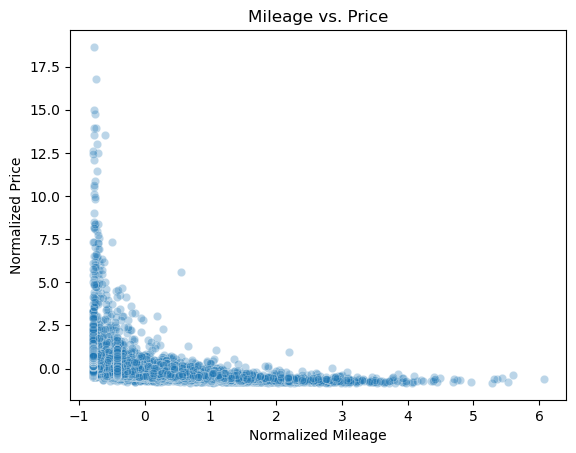

In [ ]:
sns.scatterplot(x='Mileage', y='Price', data=df, alpha=0.3)
plt.title("Mileage vs. Price")
plt.xlabel("Normalized Mileage")
plt.ylabel("Normalized Price")
plt.show()

The scatterplot shows a clear negative correlation suggesting as mileage increases, the price of the vehicle generally decreases. However, noteable observation is that for vehicles with low mileage there is a great variance of prices suggesting that other features significantly influence the price.

# Mileage Distribution by Price Quartile

C:\Users\skull\AppData\Local\Temp\ipykernel_19308\3391180069.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Price_Category', y='Mileage', data=df, palette='Blues')


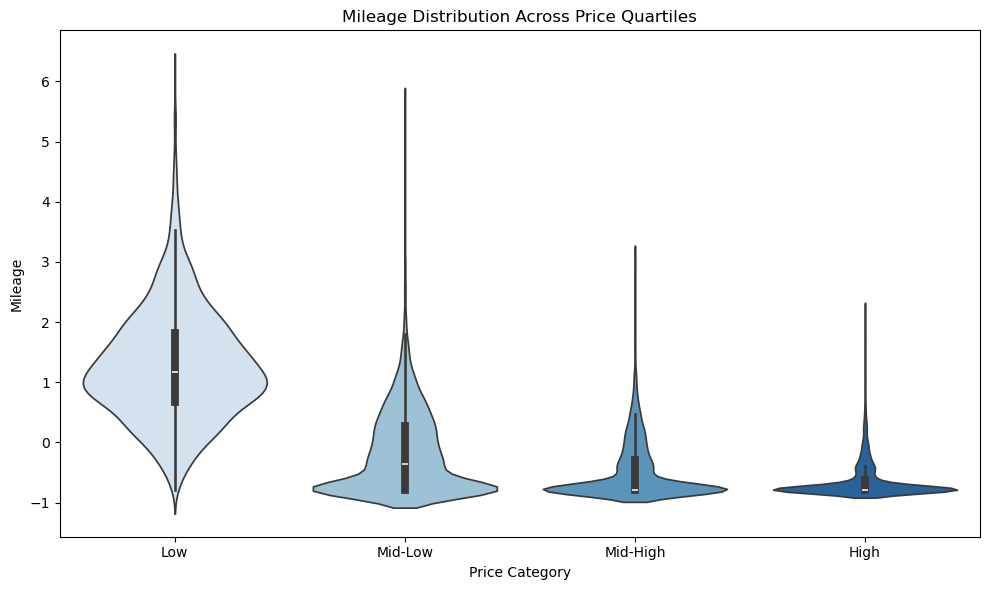

In [ ]:
df['Price_Category'] = pd.qcut(df['Price'], q=4, labels=['Low', 'Mid-Low', 'Mid-High', 'High'])

plt.figure(figsize=(10, 6))
sns.violinplot(x='Price_Category', y='Mileage', data=df, palette='Blues')
plt.title("Mileage Distribution Across Price Quartiles")
plt.ylabel("Mileage")
plt.xlabel("Price Category")
plt.tight_layout()
plt.show()

Low-priced vehicles show the widest spread in mileage, with a noticeable concentration in the high mileage range. As we move into higher price categories, mileage becomes progressively lower and more compressed, indicating newer or less-used vehicles. The high price category exhibits the lowest mileage, with almost all listings tightly clustered at the bottom of the mileage range.

Thus, we see that mileage has a strong inverse relationship with price,i.e. the higher mileage tends to reduce vehicle value. This supports its position as a top predictor in the feature importance analysis

# Engine Size Binned vs Price

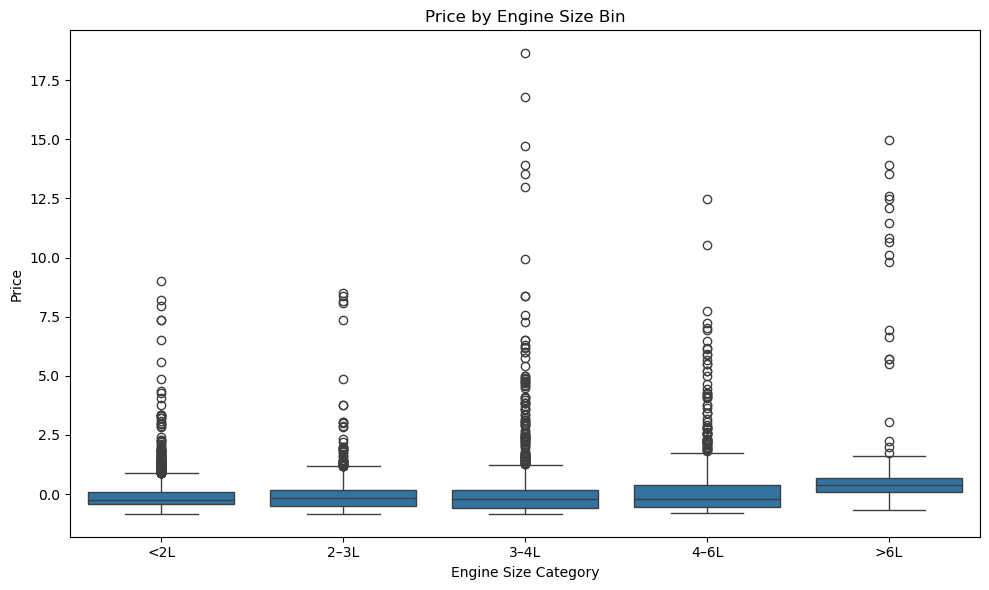

In [ ]:
df['EngineSize_Bin'] = pd.cut(df['EngineSize'], bins=[0, 2.0, 3.0, 4.0, 6.0, 10.0],
                              labels=['<2L', '2–3L', '3–4L', '4–6L', '>6L'])

plt.figure(figsize=(10, 6))
sns.boxplot(x='EngineSize_Bin', y='Price', data=df)
plt.title("Price by Engine Size Bin")
plt.xlabel("Engine Size Category")
plt.ylabel("Price")
plt.tight_layout()
plt.show()

This visualization groups vehicles into engine size ranges to evaluate how engine capacity influences price.There's a clear positive trend that prices rise with engine size.
Vehicles in the 4–6L and >6L categories show the highest median and maximum prices, often representing high-performance or luxury models.
Smaller engines (e.g., <2L) cluster around lower price brackets, indicating their presence in budget-friendly or fuel-efficient cars.
Engine size is a powerful indicator of price, reflecting both vehicle class and market expectations. Its placement in the top tier of feature importance is backed by this visual trend.

# Engine Type vs Price Boxplot

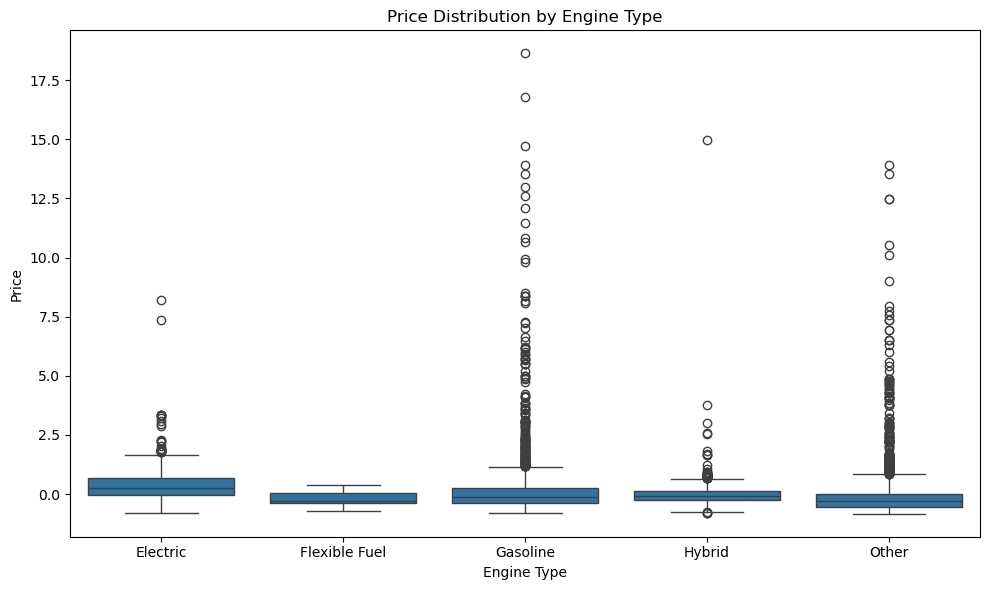

In [ ]:
engine_type_cols = [col for col in df.columns if col.startswith("EngineType_")]

engine_type_price_data = pd.DataFrame()

for col in engine_type_cols:
    temp = df[[col, 'Price']].copy()
    temp['EngineType'] = col.split('_')[-1]
    temp = temp[temp[col] == 1]
    engine_type_price_data = pd.concat([engine_type_price_data, temp[['EngineType', 'Price']]])

plt.figure(figsize=(10, 6))
sns.boxplot(x='EngineType', y='Price', data=engine_type_price_data)
plt.title("Price Distribution by Engine Type")
plt.xlabel("Engine Type")
plt.ylabel("Price")
plt.tight_layout()
plt.show()

Gasoline vehicles show the widest price range and the highest number of extreme outliers. This reflects their dominance in the dataset and wide variety across both economy and luxury segments.
Electric vehicles tend to have slightly higher median prices and tighter interquartile ranges, which may reflect their relative novelty and concentration among modern or premium models.
Hybrid and Flexible Fuel vehicles cluster lower in the price range, showing more pricing consistency but fewer high-end outliers.
The Other category displays a spread similar to gasoline vehicles, likely due to its catch-all nature and mix of configurations.

# Median Price by Rating

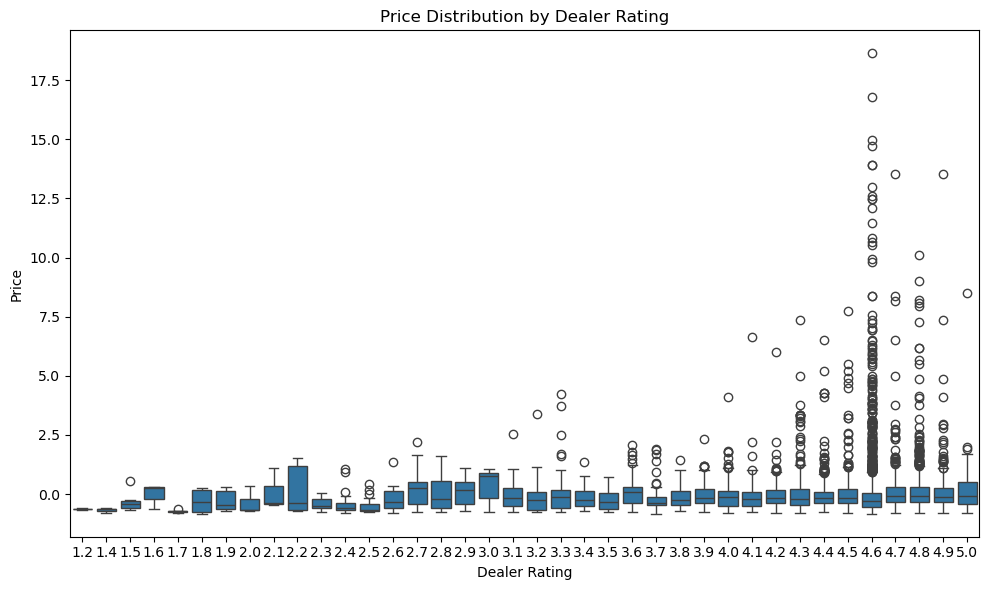

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Rating', y='Price', data=df)
plt.title("Price Distribution by Dealer Rating")
plt.xlabel("Dealer Rating")
plt.ylabel("Price")
plt.tight_layout()
plt.show()

Prices from higher-rated dealers (4.5–5.0) show a noticeably higher median and a greater spread, including several extreme outliers.
Lower-rated dealers (1.2–3.0) tend to cluster around the lower end of the price spectrum, with more consistent pricing and fewer luxury-tier listings.
There is a clear upward trend in price as dealer rating increases, especially past the 4.0 threshold.

# Cylinder Count vs Price

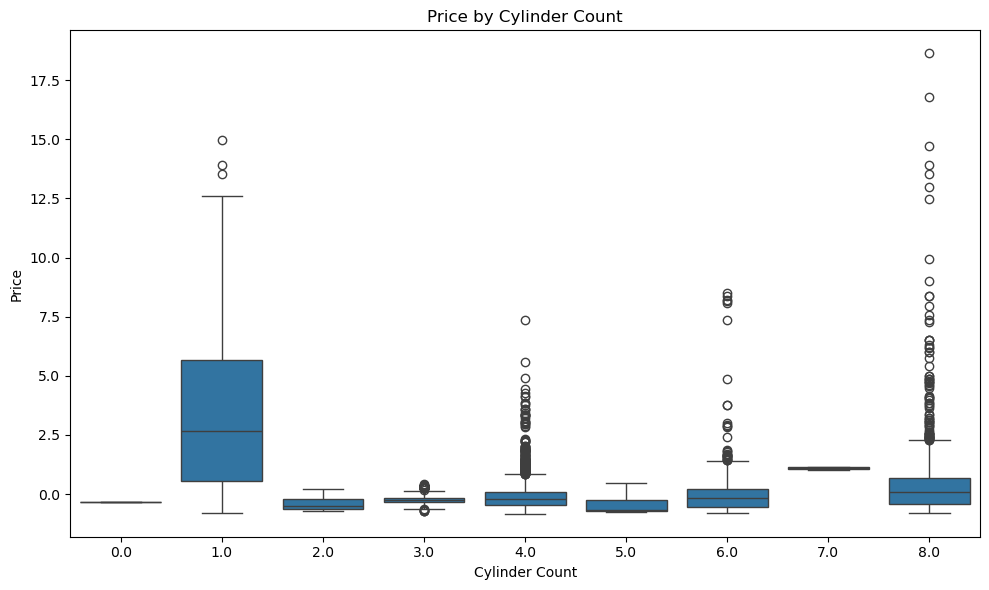

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Cylinder', y='Price', data=df)
plt.title("Price by Cylinder Count")
plt.xlabel("Cylinder Count")
plt.ylabel("Price")
plt.tight_layout()
plt.show()

The boxplot shows that vehicles with 6 or 8 cylinders tend to be listed at significantly higher prices.
4-cylinder engines have the widest spread and dominate the lower end of the market

# MPG VS PRICE

C:\Users\skull\anaconda3\Lib\site-packages\sklearn\base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.6.1 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  if left_lim + len(ellipsis) < len(repr_) - right_lim:


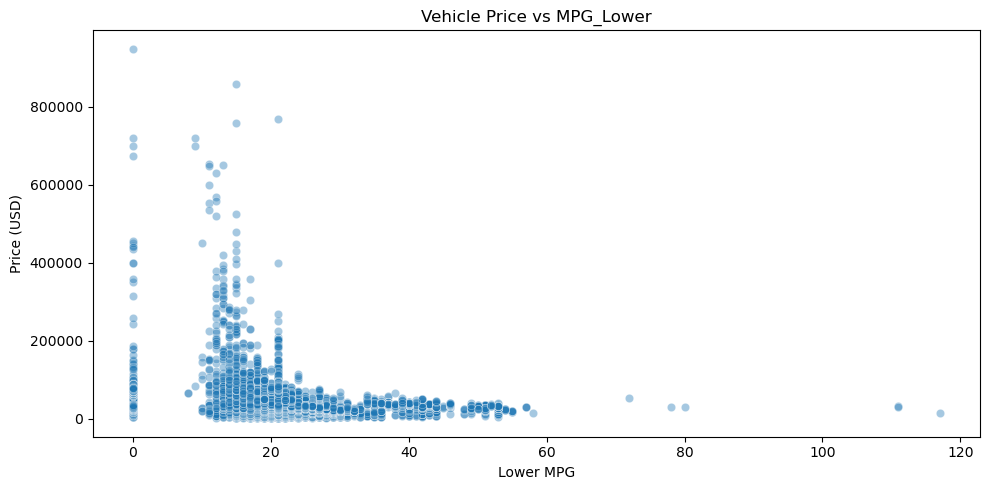

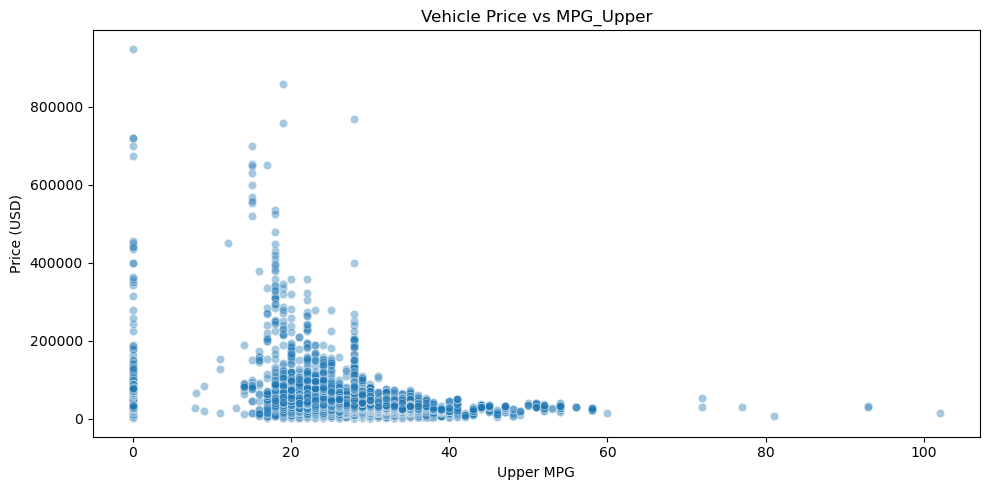

In [ ]:
scaler = joblib.load("scaler.pkl")

scaled_cols = ['Mileage', 'Price', 'Year', 'MPG_Lower', 'MPG_Upper']
df = df.dropna(subset=scaled_cols)

unscaled_values = scaler.inverse_transform(df[scaled_cols])
df['UnscaledPrice'] = unscaled_values[:, 1]        # column 1 = Price
df['UnscaledMPG_Lower'] = unscaled_values[:, 3]    # column 3 = City MPG
df['UnscaledMPG_Upper'] = unscaled_values[:, 4]    # column 4 = Highway MPG

# Plot: City MPG vs Price
plt.figure(figsize=(10, 5))
sns.scatterplot(x='UnscaledMPG_Lower', y='UnscaledPrice', data=df, alpha=0.4)
plt.title("Vehicle Price vs MPG_Lower")
plt.xlabel("Lower MPG")
plt.ylabel("Price (USD)")
plt.tight_layout()
plt.show()

# Plot: Highway MPG vs Price
plt.figure(figsize=(10, 5))
sns.scatterplot(x='UnscaledMPG_Upper', y='UnscaledPrice', data=df, alpha=0.4)
plt.title("Vehicle Price vs MPG_Upper")
plt.xlabel("Upper MPG")
plt.ylabel("Price (USD)")
plt.tight_layout()
plt.show()


Vehicles with higher MPG tend to cluster in the lower price range, reflecting the economy-class segment.
Vehicles with lower MPG show a wider spread in price, including many of the highest-priced listings — suggesting a mix of performance and luxury vehicles.
While the relationship isn’t strictly linear, the pattern supports the intuition that fuel-efficient cars are often lower-cost, and low-efficiency vehicles are typically premium or high-power models.

# Price by DriveTrain Type

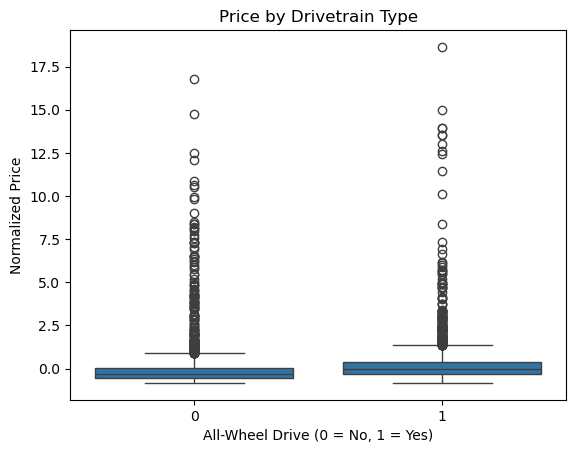

In [ ]:
sns.boxplot(x='Drivetrain_All-wheel Drive', y='Price', data=df)
plt.title("Price by Drivetrain Type")
plt.xlabel("All-Wheel Drive (0 = No, 1 = Yes)")
plt.ylabel("Normalized Price")
plt.show()

Vehicles with AWD(1) show a slightly higher median price than those without.
However, the overlap in price ranges between the two groups is substantial.
While there are more high-priced outliers among AWD vehicles, the overall difference is modest.

This visualization is primarily exploratory. While AWD may signal higher-end or utility vehicles, the chart suggests it is not a strong standalone predictor of price.

# Pairwise Feature Relationships

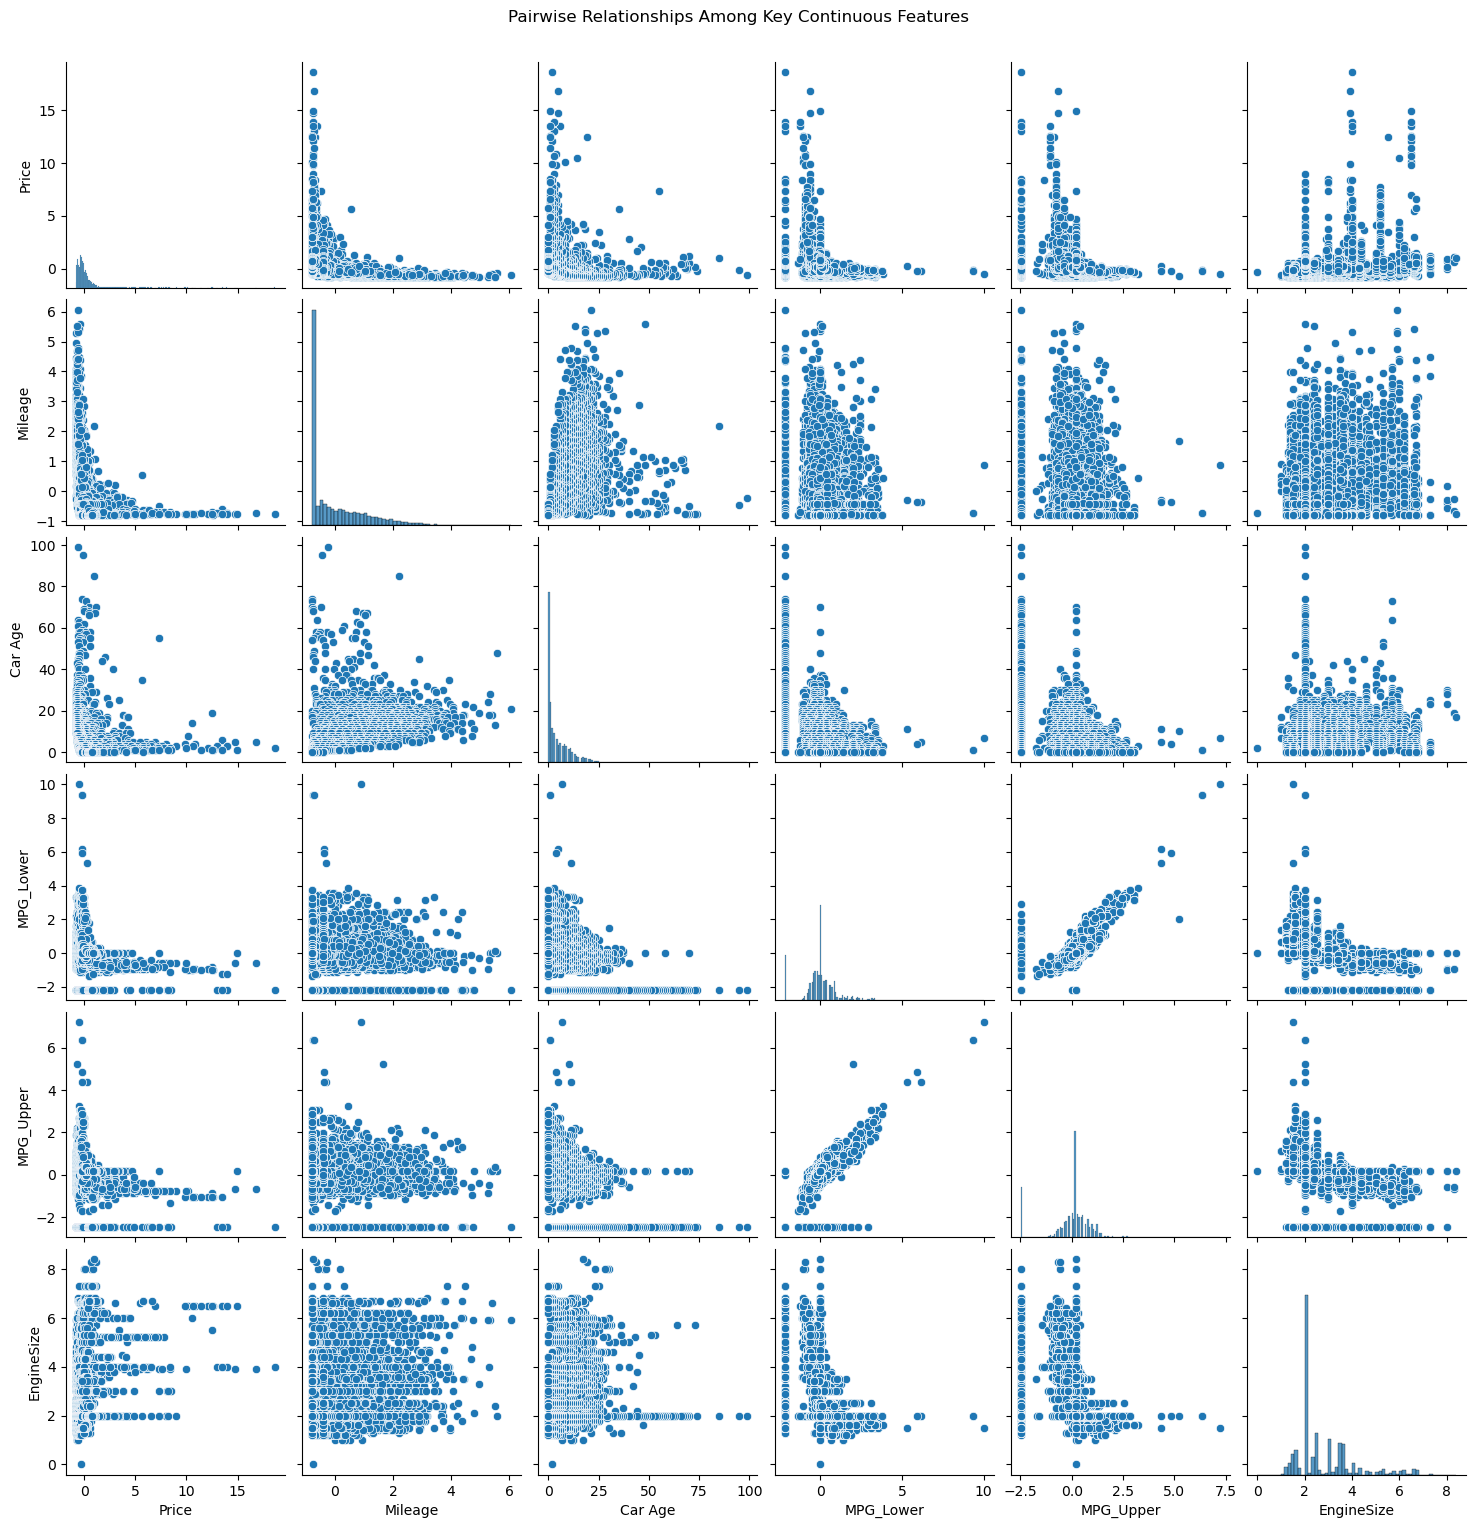

In [ ]:
selected_cols = ['Price', 'Mileage', 'Car Age', 'MPG_Lower', 'MPG_Upper', 'EngineSize']
pairplot_df = df[selected_cols].copy()

# Clean EngineSize
pairplot_df = pairplot_df.replace('-', np.nan).dropna()
pairplot_df['EngineSize'] = pairplot_df['EngineSize'].str.extract(r'(\d+\.?\d*)').astype(float)

# Plot
sns.pairplot(pairplot_df)
plt.suptitle("Pairwise Relationships Among Key Continuous Features", y=1.02)
plt.show()

- Price shows a negative curved trend with both Mileage and Car Age, aligning with expectations around vehicle depreciation.
- There's a positive linear relationship between Engine Size and Cylinders, as well as a strong upward trend between MPG_Lower and MPG_Upper, indicating mechanical dependencies.
- Several distributions, especially Price and Mileage, are heavily right-skewed, with a concentration of values in the lower range and a long tail of higher values.
- Some feature combinations (like MPG vs Price) appear noisy or weakly correlated, suggesting their influence may be contextual or non-linear.

This visual reinforces known trends like depreciation and power-price relationships, while also highlighting the need for non-linear models like Random Forest or XGBoost that can handle interaction effects.

# Feature-Based Price Comparison

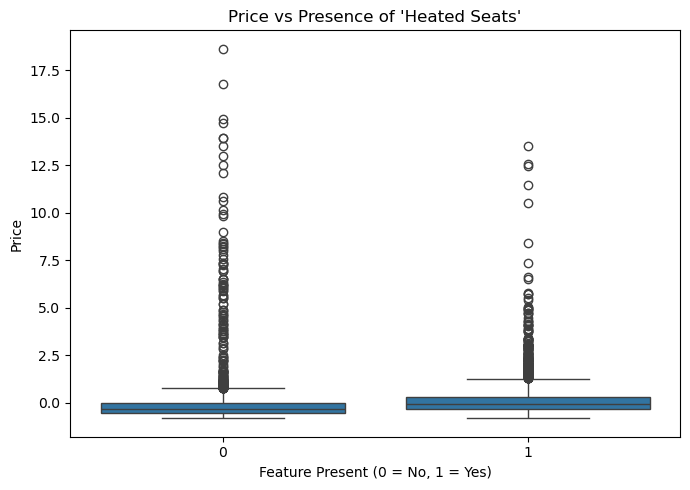

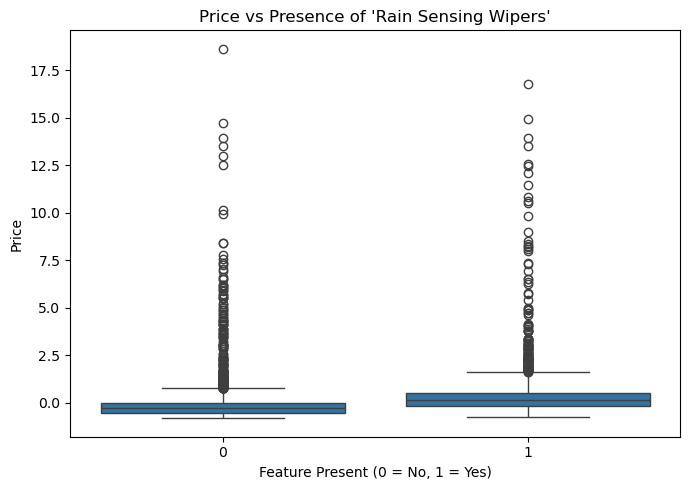

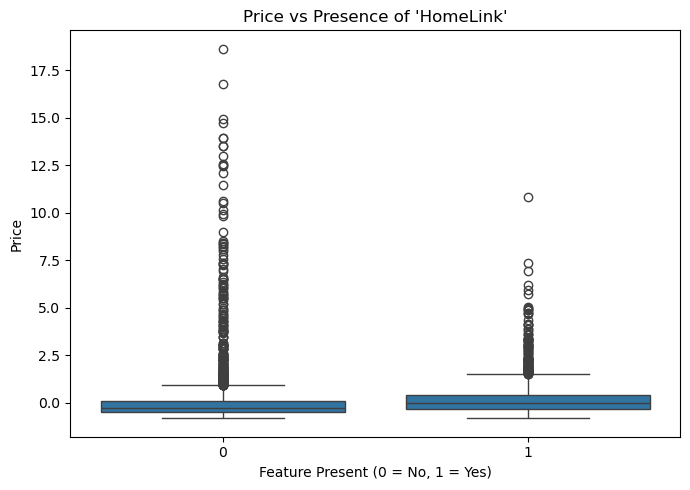

In [ ]:
feature_cols = [
    'Convenience Features_Heated Seats',
    'Safety Features_Rain Sensing Wipers',
    'Entertainment Features_HomeLink'
]

for feature in feature_cols:
    plt.figure(figsize=(7, 5))
    sns.boxplot(x=feature, y='Price', data=df)
    plt.title(f"Price vs Presence of '{feature.split('_')[-1]}'")
    plt.xlabel("Feature Present (0 = No, 1 = Yes)")
    plt.ylabel("Price")
    plt.tight_layout()
    plt.show()

In all three cases, vehicles with the feature show a slightly higher median price compared to those without. There is also a longer tail of high-priced listings among vehicles that include these features, especially for Heated Seats and Rain Sensing Wipers. However, the difference is not drastic, the majority of price distributions overlap substantially between the two groups.

These features do not strongly predict price on their own but may signal higher trim levels or modern vehicles, especially when combined. Their real value likely comes when interacting with other features (e.g., Make, EngineType), possibly making them useful supporting indicators in a model.

# Model Selection and Fine Tuning

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
#Reading in the clean and encoded csv
url = 'https://raw.githubusercontent.com/AutoTrend-Dynamics/COMP3610-Final-Project/refs/heads/main/data/Cleaned_and_Encoded_Cars.csv'
df = pd.read_csv(url)
df.head()

,Title,Dealer,Rating,Exterior Color,Interior Color,Engine,Mileage,Price,Year,Car Age,...,Safety Features_Backup Camera,Safety Features_Blind Spot Monitor,Safety Features_Brake Assist,Safety Features_LED Headlights,Safety Features_Lane Departure Warning,Safety Features_Rain Sensing Wipers,Safety Features_Rear Cross Traffic Alert,Safety Features_Stability Control,Safety Features_Unknown,Safety Features_Missing
0,Chrysler F-58,Gateway Classic Cars,2.4,Red,White,4 Cylinder,-0.225739,-0.632087,-12.620677,99,...,0,0,0,0,0,0,0,0,1,0
1,Ford Model A Base,Skyway Classics,2.9,Magenta,Tan,350 V8,-0.448202,-0.128626,-12.083210,95,...,0,0,0,0,0,0,0,0,1,0
2,Ford Pickup Truck Base,Greenwood Automotive,4.9,–,–,–,2.191959,0.981138,-10.739543,85,...,0,0,0,0,0,0,0,0,1,0
3,Chevrolet Fleetline Deluxe,California Cars,4.6,Atomic Orange Metallic,Gray,283 V8,-0.778631,-0.253931,-9.261509,74,...,0,0,0,0,0,0,0,0,1,0
4,GMC Suburban,Exotic Motorsports of Oklahoma,4.6,Black,Tan,5.7L V8,-0.775992,0.158074,-9.127142,73,...,0,0,0,0,0,0,0,0,1,0


In [ ]:
#Encodes the remaining non-numeric columns such as Make so they can be used for predictions
def one_hot_encode_non_numeric(df, drop_first=False):
    #Select non-numeric columns
    non_numeric_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

    #Apply one-hot encoding to those columns and drop them from the original
    df_encoded = pd.get_dummies(df, columns=non_numeric_cols, drop_first=drop_first,dtype=int)

    return df_encoded

In [ ]:
df = df.drop(['Title', 'Dealer'], axis=1) #drops the Title and Dealer columns as they will not be used for prediction

In [ ]:
df = one_hot_encode_non_numeric(df) #applies the one hot encode function to all non-numeric features

In [ ]:
df.columns = df.columns.str.replace(r"[\[\]<>]", "", regex=True) #Removes any special characters so the machine learning models can access them


In [ ]:
#Separate the feature matrix from the target variable
X = df.drop('Price', axis=1)
y = df['Price']

In [ ]:

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=True)

In [ ]:
print(type(X_train))

<class 'pandas.core.frame.DataFrame'>


In [ ]:
#Function used to easily evaluate models based on MAE, MSE, RMSE AND R²
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

#Function to train, predict, and evaluate regression models
def evaluate_regression_model(model, X_train, y_train, X_test, y_test):
    """Train, predict and evaluate a regression model."""
    X_train = X_train.select_dtypes(include=['number'])
    #print(X_train)
    X_test = X_test.select_dtypes(include=['number'])
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f"\nEvaluating {model.__class__.__name__}:")
    print(f"Mean Absolute Error (MAE): {mean_absolute_error(y_test, y_pred):.4f}")
    print(f"Mean Squared Error (MSE): {mean_squared_error(y_test, y_pred):.4f}")
    print(f"Root Mean Squared Error (RMSE): {np.sqrt(mean_squared_error(y_test, y_pred)):.4f}")
    print(f"R-squared (R²): {r2_score(y_test, y_pred):.4f}")

    #Plot predictions vs actual
    plt.figure(figsize=(6, 6))
    plt.scatter(y_test, y_pred, alpha=0.5, color='dodgerblue')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'Actual vs Predicted for {model.__class__.__name__}')
    plt.grid(True)
    plt.show()


## Base Models

Linear Regression, Lasso Regression, XGBoost, Random Forest and MLP will be experimented with.

Linear will be utilized due to its simplicity, interpretability, and efficiency
when modeling linear relationships as well as its ability to act as a strong baseline for comparison against more complex models.

Lasso will be utilized due to its ability to perform feature selection by shrinking less important coefficients to zero, thus reducing overfitting and improving generalization which is particularly useful for complex datasets.

XGBoost will be utilized due to its high predictive performance, regularization capabilities,robustness and strong support for feature importance

Random forest will be utilized due to its accuracy and stability as well as its effectiveness in handling both linear and non-linear relationships.

MLP will be utilized due to its capacity to identify complex non-linear patterns via deep architectures and its ability to capture interactions that traditional models might miss.





### Linear Regression


Evaluating LinearRegression:
Mean Absolute Error (MAE): 0.2368
Mean Squared Error (MSE): 0.4678
Root Mean Squared Error (RMSE): 0.6840
R-squared (R²): 0.5771


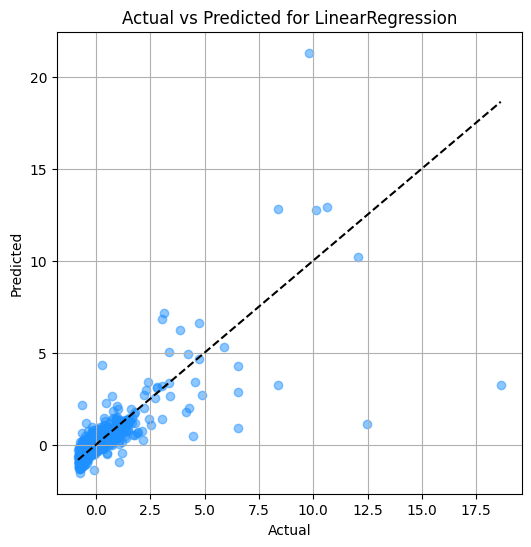

In [ ]:
evaluate_regression_model(LinearRegression(), X_train, y_train, X_test, y_test)


From the metrics above, it can be seen that linear regression performs poorly on the data. Utilizing the R² score, it is seen that the model explains only 57.7% of the variance in the target variable. MSE and RMSE also indicate relatively poor predictive performance.


Evaluating RandomForestRegressor:
Mean Absolute Error (MAE): 0.1317
Mean Squared Error (MSE): 0.1762
Root Mean Squared Error (RMSE): 0.4198
R-squared (R²): 0.8407


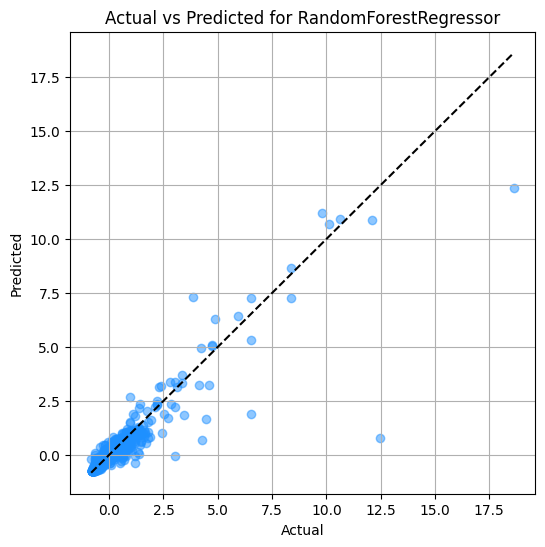

In [ ]:
evaluate_regression_model(RandomForestRegressor(), X_train, y_train, X_test, y_test) #Random Forest Model


From the metrics above, it is clear that the RandomForestRegressor performs significantly better than linear regression. The R² score shows that the model explains 84.1% of the variance in the target variable which indicates a strong fit. The lower MAE, MSE, and RMSE values also show improved predictive performance.


Evaluating XGBRegressor:
Mean Absolute Error (MAE): 0.1379
Mean Squared Error (MSE): 0.1758
Root Mean Squared Error (RMSE): 0.4193
R-squared (R²): 0.8411


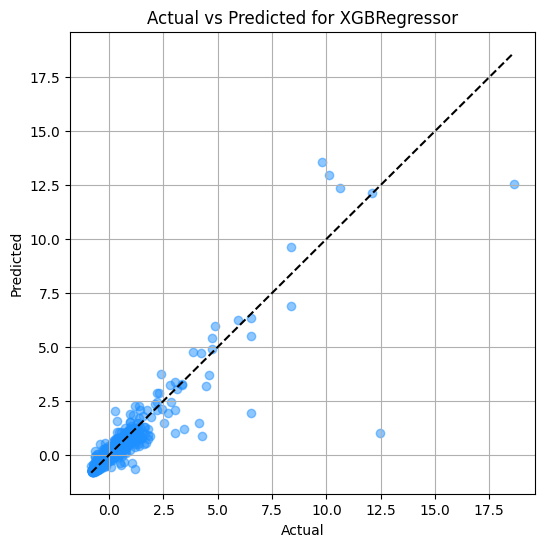

In [ ]:
evaluate_regression_model(XGBRegressor(n_estimators=200, random_state=42), X_train, y_train, X_test, y_test)


From the metrics above, it is seen that the XGBRegressor also performs very well. With an R² score of 84.1%, it explains a large portion of the variance in the target variable. The MAE, MSE, and RMSE values are all low, indicating performance that is comparable to the RandomForestRegressor and better than Linear Regression model.


Evaluating Lasso:
Mean Absolute Error (MAE): 0.3970
Mean Squared Error (MSE): 0.9340
Root Mean Squared Error (RMSE): 0.9664
R-squared (R²): 0.1558


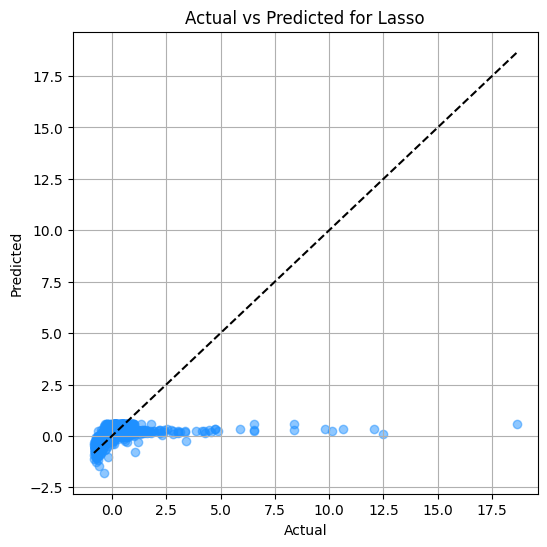

In [ ]:
evaluate_regression_model(Lasso(alpha=0.1), X_train, y_train, X_test, y_test)


From the metrics above, it can be seen that Lasso Regression performs poorly on the data. The R² score of 15.6% indicates that the model explains very little of the variance in the target variable. Additionally, the high MAE, MSE, and RMSE values highlight its weak predictive performance.


Evaluating MLPRegressor:
Mean Absolute Error (MAE): 0.1414
Mean Squared Error (MSE): 0.2148
Root Mean Squared Error (RMSE): 0.4635
R-squared (R²): 0.8058


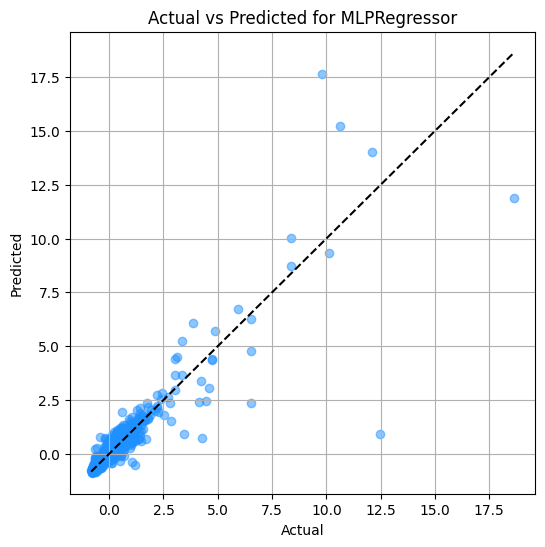

In [ ]:
from sklearn.neural_network import MLPRegressor

model_mlp = MLPRegressor(
    hidden_layer_sizes=(200, 150, 100, 50),  #4 hidden layers, decreasing size
    activation='relu',
    solver='adam',
    max_iter=1000,         #Increased iterations to help deeper net converge
    random_state=42
)

evaluate_regression_model(model_mlp, X_train, y_train, X_test, y_test)


From the metrics above, it is seen that the MLPRegressor also performs well. With an R² score of 80.6%, it explains a significant portion of the variance in the target variable. The MAE, MSE, and RMSE values are relatively low, indicating decent predictive performance, but is slightly less accurate than the XGBRegressor and Random Forest models.

Since XGBoost and Random Forest perform the best, they will be experimented with further in an attempt to maximize their predictive capabilities.

# PCA (Principal Component Analysis)

PCA was done in an attempt to determine if dimensionality reduction could improve model performance by eliminating noise and redundancy

Explained variance: 0.9504
Number of components: 76

Evaluating RandomForestRegressor:
Mean Absolute Error (MAE): 0.2125
Mean Squared Error (MSE): 0.4861
Root Mean Squared Error (RMSE): 0.6972
R-squared (R²): 0.5606


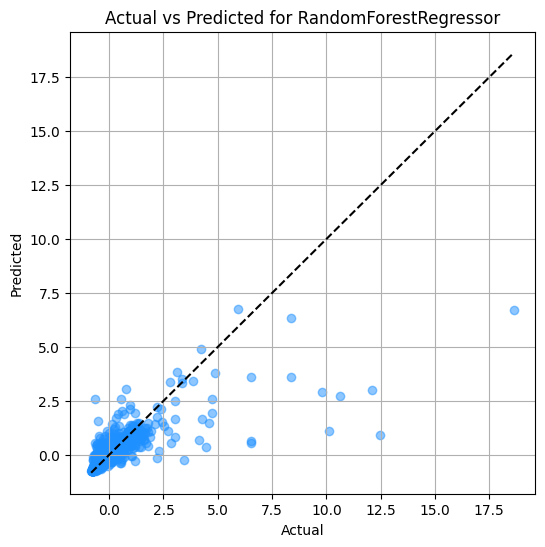

In [ ]:
from sklearn.decomposition import PCA

#Apply PCA to features
pca = PCA(n_components=0.95)  #Retain 95% variance
X_pca = pca.fit_transform(X)

print(f"Explained variance: {np.sum(pca.explained_variance_ratio_):.4f}")
print(f"Number of components: {X_pca.shape[1]}")

#Convert PCA output to df
X_pca_df = pd.DataFrame(X_pca)

#Train-test split
X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_pca_df, y, test_size=0.2, random_state=42)

#Train and evaluate Random Forest
rf_model = RandomForestRegressor(random_state=42, n_estimators=100)
evaluate_regression_model(rf_model, X_train_pca, y_train, X_test_pca, y_test)


From the metrics above, it can be seen that the Random Forest model performs considerably worse after PCA.

Explained variance: 0.9504
Number of components: 76

Evaluating XGBRegressor:
Mean Absolute Error (MAE): 0.2230
Mean Squared Error (MSE): 0.4033
Root Mean Squared Error (RMSE): 0.6351
R-squared (R²): 0.6355


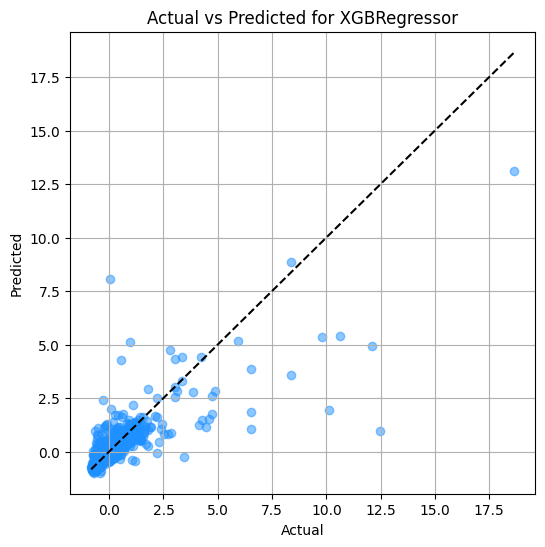

In [ ]:
#Apply PCA to features
pca = PCA(n_components=0.95)  #Retain 95% of variance
X_pca = pca.fit_transform(X)

print(f"Explained variance: {np.sum(pca.explained_variance_ratio_):.4f}")
print(f"Number of components: {X_pca.shape[1]}")

#Convert PCA output to DataFrame
X_pca_df = pd.DataFrame(X_pca)

#Train-test split
X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_pca_df, y, test_size=0.2, random_state=42)

#Train and evaluate XGBoost model
xgb_model = XGBRegressor(random_state=42, n_estimators=100)
evaluate_regression_model(xgb_model, X_train_pca, y_train, X_test_pca, y_test)


From the metrics above, it can be seen that XGBoost also performs considerably worse after PCA.

Since the performance of both XGBoost and Random Forest significantly decreases after PCA, it indicates that the models rely heavily on the original features to achieve the best values.

#Hyperparameter Tuning

Manual tuning was done to identify hyperparameters that resulted in the best performances for XGBoost and Random Forest.

### Random Forest

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
rf_model = RandomForestRegressor(

    min_samples_leaf=1, #Allows the capturing of complex patterns
    min_samples_split=2, #Allows the capturing of complex patterns
    n_estimators=200, #Higher number of trees may increases robustness and stability
    random_state=42,
    n_jobs=-1
)


Evaluating RandomForestRegressor:
Mean Absolute Error (MAE): 0.1311
Mean Squared Error (MSE): 0.1773
Root Mean Squared Error (RMSE): 0.4211
R-squared (R²): 0.8397


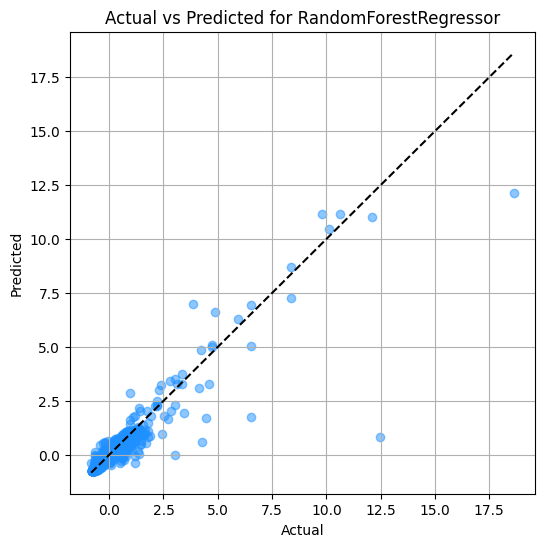

In [ ]:
#Evaluate the model
evaluate_regression_model(rf_model, X_train, y_train, X_test, y_test)

Increasing n_estimators from 200 to 300


Evaluating RandomForestRegressor:
Mean Absolute Error (MAE): 0.1302
Mean Squared Error (MSE): 0.1749
Root Mean Squared Error (RMSE): 0.4182
R-squared (R²): 0.8419


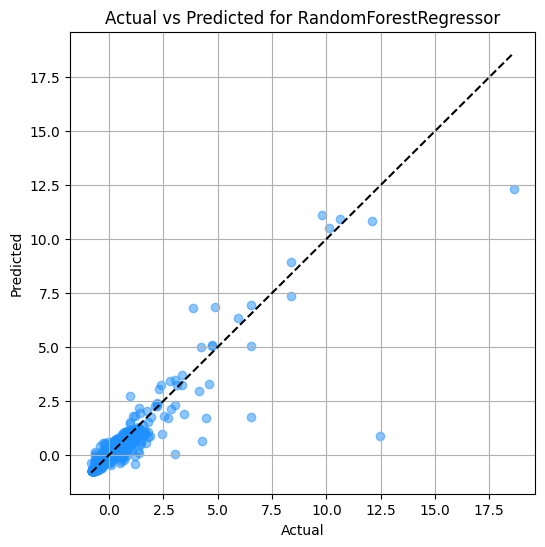

In [ ]:
best_rf_model = RandomForestRegressor(
    max_depth=None,
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=500,
    random_state=42,
    n_jobs=-1
)

#Evaluate the model
evaluate_regression_model(best_rf_model, X_train, y_train, X_test, y_test)


From the metrics above, it can be seen that the Random Forest Model with the provided configuration performs the better of the two Random Forest models.

### XGBoost

In [ ]:
#Define model with maxed-out parameters for XGBoost
model_xgb = XGBRegressor(
    n_estimators=1000,              #Large number of estimators
    max_depth=15,                   #Large max depth for deep trees
    learning_rate=0.01,             #Small learning rate for slow but steady learning
    subsample=0.8,                  #Sample 80% of data for each tree
    colsample_bytree=0.8,           #Randomly sample features per tree
    reg_alpha=1.0,                  #L1 regularization
    reg_lambda=1.0,                 #L2 regularization
    gamma=0.1,                      #Minimum loss reduction required to make a further partition
    min_child_weight=1,             #Minimum sum of instance weight needed in a child
    scale_pos_weight=1,             #Balance of positive and negative weights
    random_state=42,
    verbosity=1,
    objective='reg:squarederror'
)



Evaluating XGBRegressor:
Mean Absolute Error (MAE): 0.1342
Mean Squared Error (MSE): 0.1559
Root Mean Squared Error (RMSE): 0.3949
R-squared (R²): 0.8591


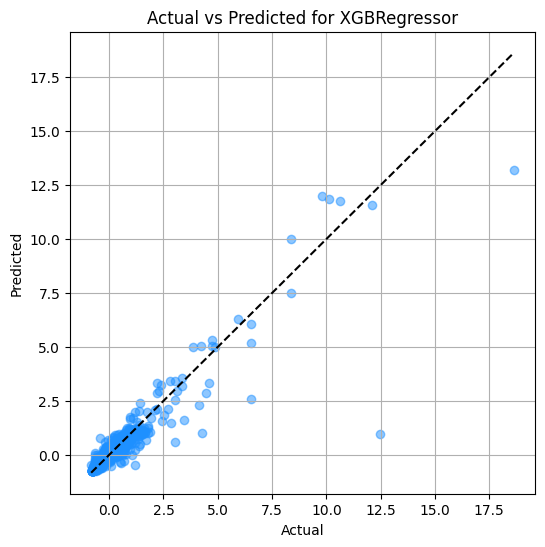

In [ ]:
#Train and evaluate
evaluate_regression_model(model_xgb, X_train, y_train, X_test, y_test)

The above model is the best performing, with an R² of 0.8591, indicating strong predictive power and low error metrics across MAE, MSE, and RMSE

Confirming the performance of the XGBoost model using cross validation.

In [ ]:
def xgb_with_cv(X_train, y_train, X_test, y_test):
    #Same paramaters as the best performing XGBoost model
    model_params = {
        'n_estimators': 1000,
        'max_depth': 15,
        'learning_rate': 0.01,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'reg_alpha': 1.0,
        'reg_lambda': 1.0,
        'gamma': 0.1,
        'min_child_weight': 1,
        'scale_pos_weight': 1,
        'random_state': 42,
        'verbosity': 1,
        'objective': 'reg:squarederror'
    }

    kf = KFold(n_splits=5, shuffle=True, random_state=42) #5-fold cross validation with shuffling
    mae_list, rmse_list, r2_list = [], [], [] #prepare metric evaluation

    for train_idx, val_idx in kf.split(X_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx] #Subset of data for training
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx] #Subset of data for validating
        #Double checks that data is numeric
        X_tr = X_tr.select_dtypes(include='number')
        X_val = X_val.select_dtypes(include='number')

        model = XGBRegressor(**model_params) #Initialize XGBoost model
        model.fit(X_tr, y_tr) #Fit model to traiing data
        y_pred = model.predict(X_val) #Test on the validation set
        #Calculate metrics for current fold
        mae_list.append(mean_absolute_error(y_val, y_pred))
        rmse_list.append(np.sqrt(mean_squared_error(y_val, y_pred)))
        r2_list.append(r2_score(y_val, y_pred))

    print("Average CV MAE:", np.mean(mae_list))
    print("Average CV RMSE:", np.mean(rmse_list))
    print("Average CV R²:", np.mean(r2_list))

    #Final test evaluation
    X_train_filtered = X_train.select_dtypes(include='number')
    X_test_filtered = X_test.select_dtypes(include='number')

    final_model = XGBRegressor(**model_params)
    final_model.fit(X_train_filtered, y_train)
    y_test_pred = final_model.predict(X_test_filtered)

    print("\nTest Set Results:")
    print("MAE:", mean_absolute_error(y_test, y_test_pred))
    print("RMSE:", np.sqrt(mean_squared_error(y_test, y_test_pred)))
    print("R²:", r2_score(y_test, y_test_pred))

    #Actual vs Predicted
    plt.figure(figsize=(6, 6))
    plt.scatter(y_test, y_test_pred, alpha=0.5, color='dodgerblue')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title("Test Set: Actual vs Predicted")
    plt.grid(True)
    plt.show()


Average CV MAE: 0.1373629714523205
Average CV RMSE: 0.379974859389906
Average CV R²: 0.8462598935913735

Test Set Results:
MAE: 0.13419719921257386
RMSE: 0.39487783122262016
R²: 0.8590584371211714


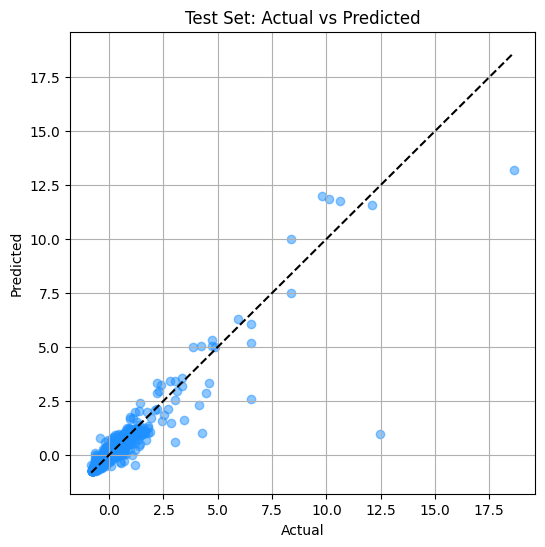

In [ ]:
xgb_with_cv(X_train, y_train, X_test, y_test)

Overall, cross-validation has confirmed that the xgboost model performs well across all folds, and is suitable for api and dashboard implementation.

# Reducing Features


For the sake of interpretability and ease of implementation, a simple subset of the data was considered.

## Using Rating, Mileage, Year, Make and Engine-related features

In [ ]:
X = ['Rating', 'Mileage', 'Year'] #Rating, Mileage and Year features
make_cols = [col for col in df.columns if col.startswith("Make")] #Make columns(one hot encoded )
engine_cols = [col for col in df.columns if col.startswith("Engine")] #All engine-related features

X = df[X + make_cols + [col for col in engine_cols if col not in X]]


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Evaluating RandomForestRegressor:
Mean Absolute Error (MAE): 0.1512
Mean Squared Error (MSE): 0.2055
Root Mean Squared Error (RMSE): 0.4533
R-squared (R²): 0.8143


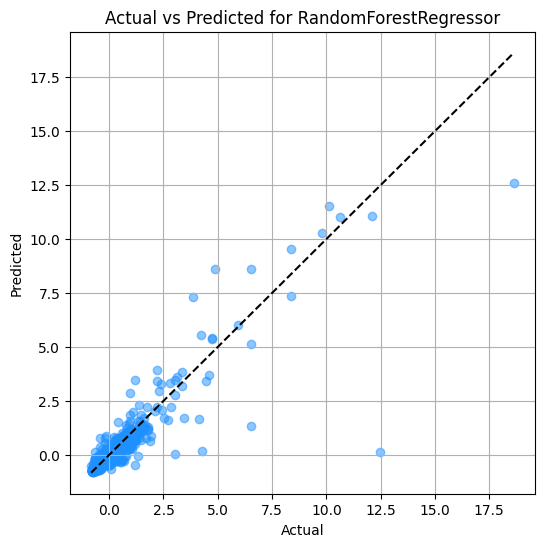

In [ ]:
evaluate_regression_model(rf_model, X_train, y_train, X_test, y_test)


Evaluating XGBRegressor:
Mean Absolute Error (MAE): 0.1666
Mean Squared Error (MSE): 0.2103
Root Mean Squared Error (RMSE): 0.4585
R-squared (R²): 0.8100


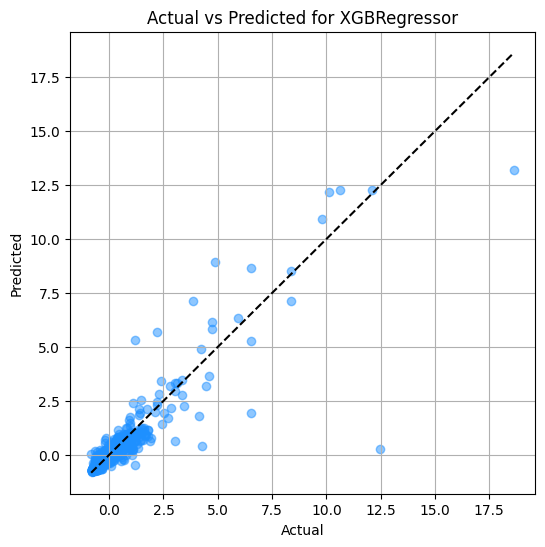

In [ ]:
evaluate_regression_model(model_xgb, X_train, y_train, X_test, y_test)

Both Random Forest and XGBoost perform well given this particular subset of features, but many of the Engine columns may be difficult to implement via an API, therefore simpler features need to be considered while also retaining as much performance as possible.

### Rating, Mileage, Year, Make and EngineType

These features are very simple and can be understood by stakeholders such as managers and marketing teams.

In [ ]:
X = ['Rating', 'Mileage', 'Year']
make_cols = [col for col in df.columns if col.startswith("Make")]
engine_type_cols = [col for col in df.columns if col.startswith("EngineType")] #Specifically the EngineType features(One Hot Encoded)

X = df[X + make_cols + [col for col in engine_type_cols if col not in X]]


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Evaluating RandomForestRegressor:
Mean Absolute Error (MAE): 0.2163
Mean Squared Error (MSE): 0.2717
Root Mean Squared Error (RMSE): 0.5213
R-squared (R²): 0.7544


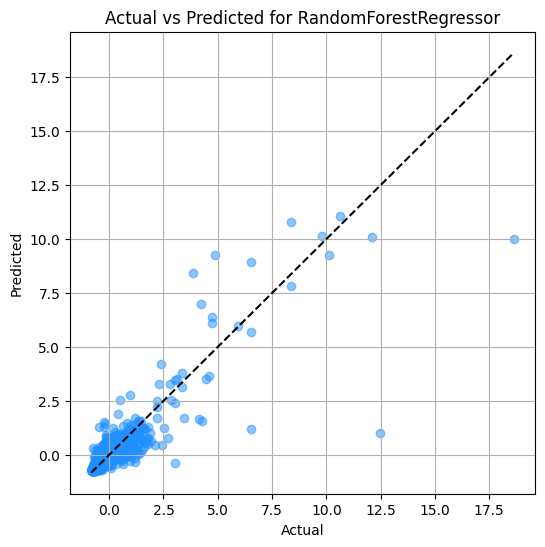

In [ ]:
evaluate_regression_model(rf_model, X_train, y_train, X_test, y_test) #evaluate with random forest


Evaluating XGBRegressor:
Mean Absolute Error (MAE): 0.2239
Mean Squared Error (MSE): 0.2753
Root Mean Squared Error (RMSE): 0.5247
R-squared (R²): 0.7512


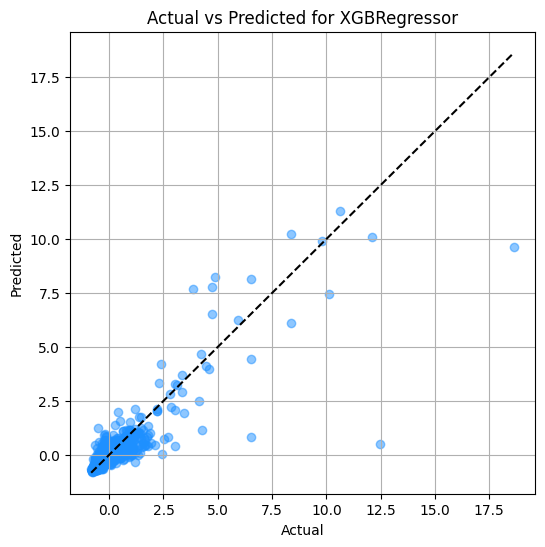

In [ ]:
evaluate_regression_model(model_xgb, X_train, y_train, X_test, y_test) #evaluate with XGBoost

These features have provided considerably worse metrics compared to the ideal XGBoost model which had an RMSE of 0.3949 and R² of 0.8591, but given that it was a tradeoff between simplicity and performance, and the model still performs decently, it will be chosen for the API implementation. Using this configuration, Random Forest will be used since it slightly outperforms the XGBoost model.

#Exporting Random Forest model

In [ ]:
from google.colab import drive #mount drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import joblib
#Save trained model
joblib.dump(rf_model, '/content/drive/MyDrive/rf_model.pkl')


['/content/drive/MyDrive/rf_model.pkl']

In [ ]:
#Exporting model with fixed scaling issue
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

joblib.dump(model, 'rf_model_cleaned.pkl')

# API

In [ ]:
!pip install fastapi uvicorn[standard] python-multipart joblib nest-asyncio
!pip install scikit-learn --upgrade

  You can safely remove it manually.


   ---------------------------------------- 0.0/11.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/11.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/11.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/11.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/11.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/11.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/11.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/11.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/11.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/11.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/11.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/11.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/11.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/11.1 MB ? eta -:--:--
   -----------------

In [ ]:
import pandas as pd
import joblib
import nest_asyncio
import uvicorn
import threading
from fastapi import FastAPI
from pydantic import BaseModel

# Creating FastAPI

In [ ]:
nest_asyncio.apply()

model = joblib.load("rf_model_cleaned.pkl")
scaler = joblib.load("scaler.pkl")

df = pd.read_csv("Cleaned_and_Encoded_Cars.csv")

# Rebuild full model input feature set
full_features = model.feature_names_in_.tolist()
make_cols = [col for col in full_features if col.startswith("Make_")]
state_cols = [col for col in full_features if col.startswith("State_")]
engine_cols = [col for col in full_features if col.startswith("EngineType_")]

class CarFeatures(BaseModel):
    Rating: float
    Mileage: float
    Year: int
    Make: str
    State: str  # 2-letter state code
    EngineType: str

def build_input_vector(data: CarFeatures):
    input_data = dict.fromkeys(full_features, 0)

    input_data['Rating'] = data.Rating
    input_data['Mileage'] = data.Mileage
    input_data['Year'] = data.Year

    make_key = f"Make_{data.Make}"
    state_key = f"State_{data.State.upper()}"
    engine_key = f"EngineType_{data.EngineType}"

    if make_key in make_cols:
        input_data[make_key] = 1
    if state_key in state_cols:
        input_data[state_key] = 1
    if engine_key in engine_cols:
        input_data[engine_key] = 1

    return pd.DataFrame([input_data])[full_features]

#Create FastAPI app
app = FastAPI(title="Vehicle Price Prediction API", version="3.0")

@app.post("/predict")
def predict_price(features: CarFeatures):
    try:
        X_input = build_input_vector(features)
        scaled_price = model.predict(X_input)
        actual_price = scaler.inverse_transform([[0, scaled_price[0], 0, 0, 0]])[0][1]  # Index 1 = Price
        return {"predicted_price": round(actual_price, 2)}
    except Exception as e:
        return {"error": str(e)}

# Running the API

In [ ]:
def run_api():
    uvicorn.run(app, host="127.0.0.1", port=8003)



In [ ]:
thread = threading.Thread(target=run_api)
thread.start()

# Creating the Streamlit Dashboard

In [ ]:
#!pip install streamlit

import streamlit as st
import pandas as pd
import plotly.express as px
import altair as alt
import numpy as np
import plotly.graph_objects as go

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures

# Load the dataset

In [ ]:
@st.cache_data
def load_data():
    df = pd.read_csv("Cars_Data.csv")
    df.dropna(subset=["Price", "Mileage", "Year", "Make", "State"], inplace=True)
    return df

df = load_data()

In [ ]:
st.title("Car Pricing Advisor")

# Sidebar
st.sidebar.header("Filter Listings")
st.markdown("Use the Filter to explore car listings and identify competitive price ranges.")

states = df["State"].unique()
makes = df["Make"].unique()
years = df["Year"].astype(int)

selected_state = st.sidebar.selectbox("Select State", sorted(states))
selected_make = st.sidebar.selectbox("Select Car Model", sorted(makes))
year_range = st.sidebar.slider("Manufacturing Year", int(years.min()), int(years.max()), (2000, 2024))
mileage_max = st.sidebar.slider("Maximum Mileage", int(df["Mileage"].min()), int(df["Mileage"].max()), int(df["Mileage"].max()))

# Filter the Data
filtered_df = df[
    (df["State"] == selected_state) &
    (df["Make"] == selected_make) &
    (df["Year"] >= year_range[0]) & (df["Year"] <= year_range[1]) &
    (df["Mileage"] <= mileage_max)
]

st.subheader(f"Matching Listings for {selected_make} in {selected_state}")

In [ ]:
if filtered_df.empty:
    st.warning("No listings match the selected criteria. Try relaxing your filters.")
else:
    st.write(f"Filtered to display listings between {year_range[0]} and {year_range[1]} with mileage under {mileage_max:,}.")
    st.dataframe(filtered_df[["Price", "Year", "Make", "Mileage", "Drivetrain", "Fuel Type", "Convenience Features", "Entertainment Features", "Exterior Features", "Safety Features"]])

    # Average Price
    avg_price = filtered_df["Price"].mean()
    min_price = filtered_df["Price"].min()
    max_price = filtered_df["Price"].max()

    st.success(f"Suggested Price Range: ${min_price:,.0f} – ${max_price:,.0f}")
    st.info(f"Average Price: ${avg_price:,.0f}")

    # For Future Trends
    yearly_prices = filtered_df.groupby('Year')['Price'].mean().reset_index()

    X = yearly_prices[['Year']]
    y = yearly_prices['Price']
    model = LinearRegression()
    model.fit(X, y)

    # Predict next 6 years
    future_years = pd.DataFrame({'Year': np.arange(filtered_df['Year'].max()+1, filtered_df['Year'].max()+7)})
    future_prices = model.predict(future_years)

    # Combine actual and predicted
    future_df = future_years.copy()
    future_df['Price'] = future_prices
    future_df['Type'] = 'Predicted'
    yearly_prices['Type'] = 'Actual'
    combined_df = pd.concat([yearly_prices, future_df])

    st.write("")
    st.title("Trends from the Filtered Listings")

    #  =========== Filtered Visuals =============

    st.write("")
    st.subheader("Price vs Mileage")

    smoothed_df = filtered_df[["Mileage", "Price"]].sort_values("Mileage")

    # Fit Polynomial Regression (2nd degree for smooth curve)
    X1 = smoothed_df["Mileage"].values.reshape(-1, 1)
    y1 = smoothed_df["Price"].values
    poly = PolynomialFeatures(degree=2)
    X_poly = poly.fit_transform(X1)
    model = LinearRegression().fit(X_poly, y1)
    y_pred = model.predict(X_poly)

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=smoothed_df["Mileage"], y=smoothed_df["Price"],
                            mode='markers', name='Actual Data', opacity=0.4))
    fig.add_trace(go.Scatter(x=smoothed_df["Mileage"], y=y_pred,
                            mode='lines', name='Price vs Mileage', line=dict(color='white', width=3)))

    fig.update_layout(title="The graph shows that as the mileage of a vehicle increases, the price decreases",
                    xaxis_title="Mileage",
                    yaxis_title="Price",
                    height=400)

    st.plotly_chart(fig, use_container_width=True)


    st.subheader("Average Price of Vehicle by Year")
    avg_by_year = (
        filtered_df.groupby("Year")["Price"]
        .mean()
        .reset_index()
        .sort_values("Year")
    )
    st.line_chart(avg_by_year, x="Year", y="Price")

    st.subheader("Manufacturing Year vs Price")
    st.scatter_chart(filtered_df[["Year", "Price"]])

    st.subheader("Car Price Trends and Predictions")

    st.write("The graph below shows the predicted trend for car prices for the next six years")

    line_chart = alt.Chart(combined_df).mark_line(point=True).encode(
        x='Year:O',
        y='Price:Q',
        color='Type:N'
    ).properties(width=700)

    st.altair_chart(line_chart, use_container_width=True)

    # =========== General Visuals =============

    st.write("")
    st.title("General Car Trends")

    st.subheader("Most Common Car Makes")
    top_makes = df["Make"].value_counts().head(10)
    st.bar_chart(top_makes)

    st.subheader("Listings by State")
    state_counts = df["State"].value_counts()
    st.bar_chart(state_counts)

    st.subheader("Exterior Color Popularity")
    color_counts = df["Exterior Color"].value_counts().head(10)
    st.bar_chart(color_counts)

